In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 278990957 / Gaia DR3 5483610730803645312  Analysis (EA)

- new VSX entry
- contaminated by TIC 278990954 (TESS=10.19; 16" to the SE) and TIC 278990956 (TESS=12.80; 10" to the E).
- the target has lightcurves from QLP / TGLC, but the out-of-ecliipses systematics are quite severe
  - so the final plot is based on the SPOC / TESS SPOC data of the nearby TIC 278990954, with less systematics and higher cadence. The corrected range is comparable to those of QLP / TGLC.


## TESS Data, determining the pipeline to be used

### TESS Data of the contaminant

- the contaminant has cleaner (and higher cadence) SPOC / TESS-SPOC data, useful for accurate measurement of period / epoch


In [11]:
tic_contaminant = 278990954

sr_c = lk.search_lightcurve(f"TIC{tic_contaminant}", )  # author="SPOC", cadence="short"
sr_unfiltered_c = sr_c  # keep a copy
sr_c = lke.filter_by_priority(sr_c, author_priority = ["SPOC", "TESS-SPOC", "QLP", "TGLC", "GSFC-ELENAOR-LITE"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr_c)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess_c= sr_c.download_all()
lcc_tess_c

SearchResult containing 36 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 01 2018 TESS-SPOC    1800   278990954      0.0         N/A
  1 TESS Sector 02 2018 TESS-SPOC    1800   278990954      0.0         N/A
  2 TESS Sector 03 2018 TESS-SPOC    1800   278990954      0.0         N/A
  3 TESS Sector 05 2018 TESS-SPOC    1800   278990954      0.0         N/A
  4 TESS Sector 06 2018 TESS-SPOC    1800   278990954      0.0         N/A
  5 TESS Sector 07 2019 TESS-SPOC    1800   278990954      0.0         N/A
  6 TESS Sector 08 2019 TESS-SPOC    1800   278990954      0.0         N/A
  7 TESS Sector 09 2019 TESS-SPOC    1800   278990954      0.0         N/A
  8 TESS Sector 10 2019 TESS-SPOC    1800   278990954      0.0         N/A
  9 TESS Sector 11 2019      SPOC     120   278990954      0.0     G011291
 10 TESS Sector 12 2019      SPOC     120   278990954      0.0     G011291
 11 TESS Sector 13 2019      SPOC     120   278990954      0.0     G011291
 12 TESS Sector 27 2020      SPOC     120   278990954      0.0      G03188
 13 TESS Sector 28 2020      SPOC     120   278990954      0.0      G03188
 14 TESS Sector 29 2020      SPOC     120   278990954      0.0      G03188
 15 TESS Sector 30 2020      SPOC     120   278990954      0.0      G03188
 16 TESS Sector 31 2020      SPOC     120   278990954      0.0      G03188
 17 TESS Sector 32 2020      SPOC     120   278990954      0.0      G03188
 18 TESS Sector 33 2020      SPOC     120   278990954      0.0      G03188
 19 TESS Sector 35 2021      SPOC     120   278990954      0.0      G03188
 20 TESS Sector 36 2021      SPOC     120   278990954      0.0      G03188
 21 TESS Sector 37 2021      SPOC     120   278990954      0.0      G03188
 22 TESS Sector 38 2021      SPOC     120   278990954      0.0      G03188
 23 TESS Sector 39 2021      SPOC     120   278990954      0.0      G03188
 24 TESS Sector 61 2023 TESS-SPOC     200   278990954      0.0         N/A
 25 TESS Sector 62 2023 TESS-SPOC     200   278990954      0.0         N/A
 26 TESS Sector 63 2023 TESS-SPOC     200   278990954      0.0         N/A
 27 TESS Sector 64 2023 TESS-SPOC     200   278990954      0.0         N/A
 28 TESS Sector 65 2023 TESS-SPOC     200   278990954      0.0         N/A
 29 TESS Sector 66 2023 TESS-SPOC     200   278990954      0.0         N/A
 30 TESS Sector 67 2023 TESS-SPOC     200   278990954      0.0         N/A
 31 TESS Sector 68 2023 TESS-SPOC     200   278990954      0.0         N/A
 32 TESS Sector 69 2023 TESS-SPOC     200   278990954      0.0         N/A
 33 TESS Sector 87 2024      SPOC     120   278990954      0.0      G07036
 34 TESS Sector 88 2025      SPOC     120   278990954      0.0      G07036
 35 TESS Sector 89 2025      SPOC     120   278990954      0.0      G07036

LightCurveCollection of 36 objects:
    0: <TessLightCurve LABEL="TIC 278990954" SECTOR=1 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 278990954" SECTOR=2 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 278990954" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 278990954" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 278990954" SECTOR=6 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 278990954" SECTOR=7 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 278990954" SECTOR=8 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 278990954" SECTOR=9 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 278990954" SECTOR=10 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 278990954" SECTOR=11 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 278990954" SECTOR

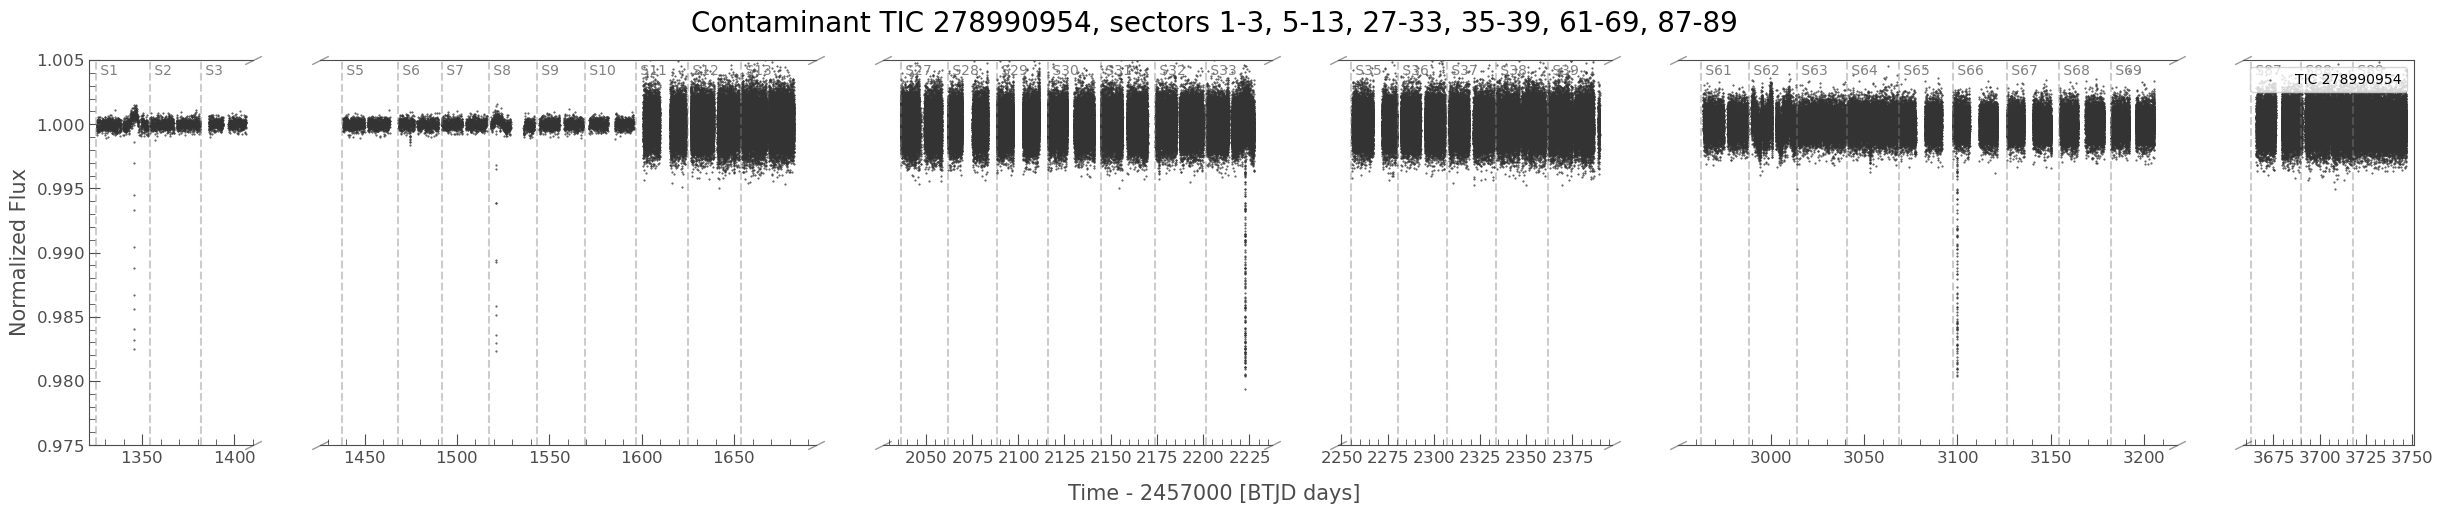

In [20]:
lc = lke.stitch(lcc_tess_c, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f"Contaminant {lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.975, 1.005) for ax in axs];

#### Determine initial period / epoch by inspection

- use contaminant data as it has higher cadence


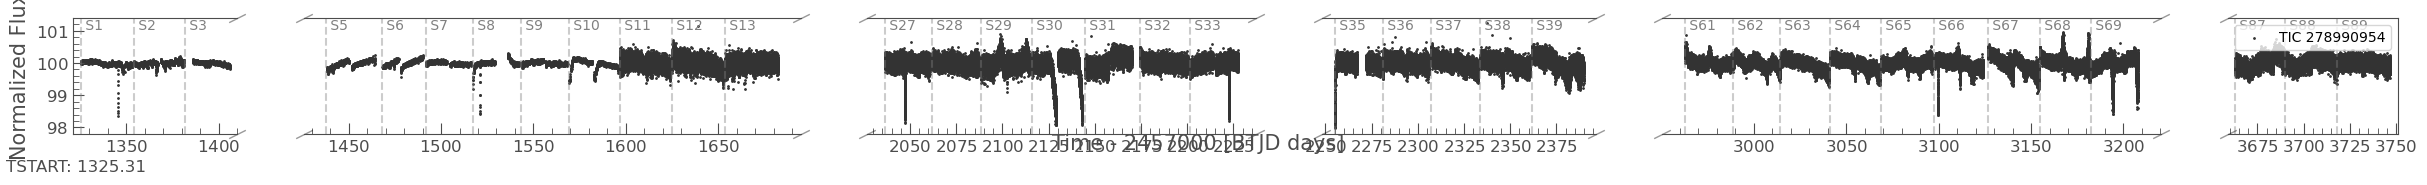

Output(layout=Layout(border_bottom='1px solid lightgray', border_left='1px solid lightgray', border_right='1px…

Output(layout=Layout(padding='1em'))

In [19]:
flux_col = "sap_flux"
lc = lke.stitch(lcc_tess_c, corrector_func=lambda lc: lc.select_flux(flux_col).normalize(unit="percent"), ignore_incompatible_column_warning=True,)

transit_interactive_defaults = dict(epoch=1521.12, label="EB deep",
                                    duration_hr=6.5, period=175.394, 
                                    cycle=0, surround_time=5, moving_avg_window='30min')

axs = tplt.plot_skip_data_gap(lc, figsize=(30, 1.5)); # a small overall view
axs[0].set_xlabel(f"TSTART: {lc.meta.get('TSTART', 0):.2f}", x=0.02, fontsize=12) #  To aid relative time conversion

tplt.plot_transit_interactive(lc, figsize=(30, 8),
                              defaults=transit_interactive_defaults,
                              plot_kwargs=dict(normalize=False),
                             );

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\tic_plot.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  return plt.figure(*args, **kwargs).gca()


0 EB-deep
    [1345.73]
    [1521.12]
    [2047.3]
    [2222.7]
    [3099.67]
1 EB-shallow
    [1474.63]
    [1650.02]
    [2176.2]
    [2351.6]
    [3053.17]
2 s0001s0039tce1
    [1635.01]
    [2386.19]
    [3137.37]
3 s0001s0039tce2
    [1388.34]
    [1527.4]
    [1666.46]
    [2222.69]
    [3057.04]
    [3196.1]


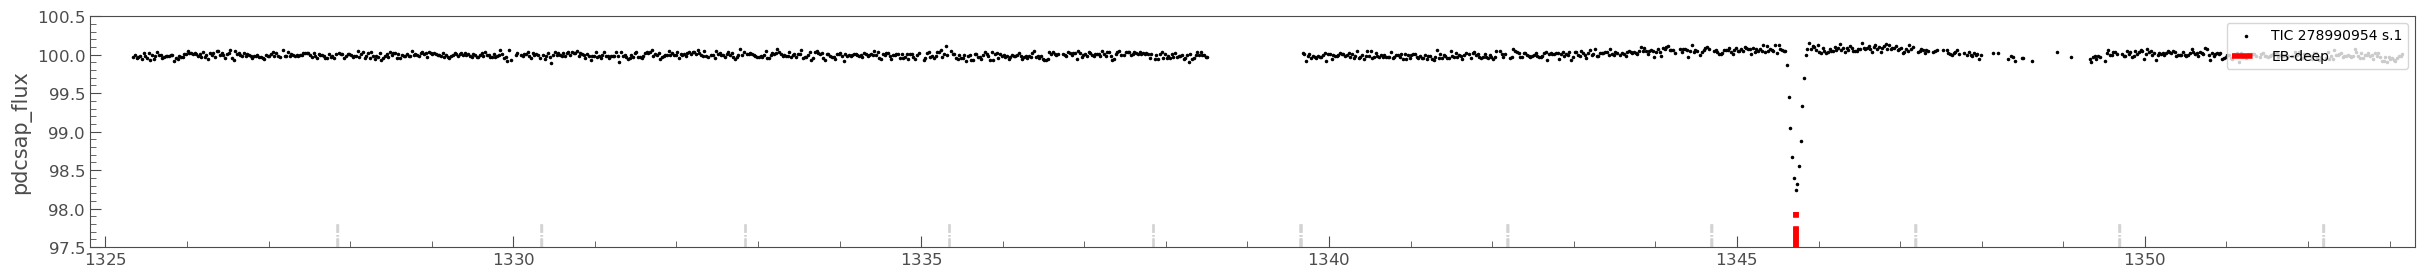

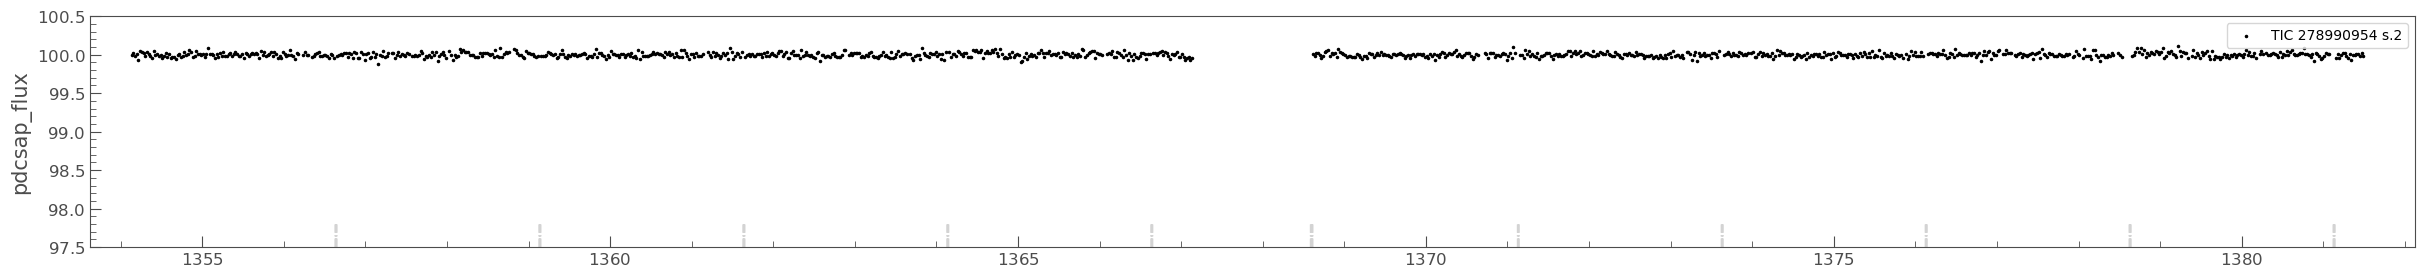

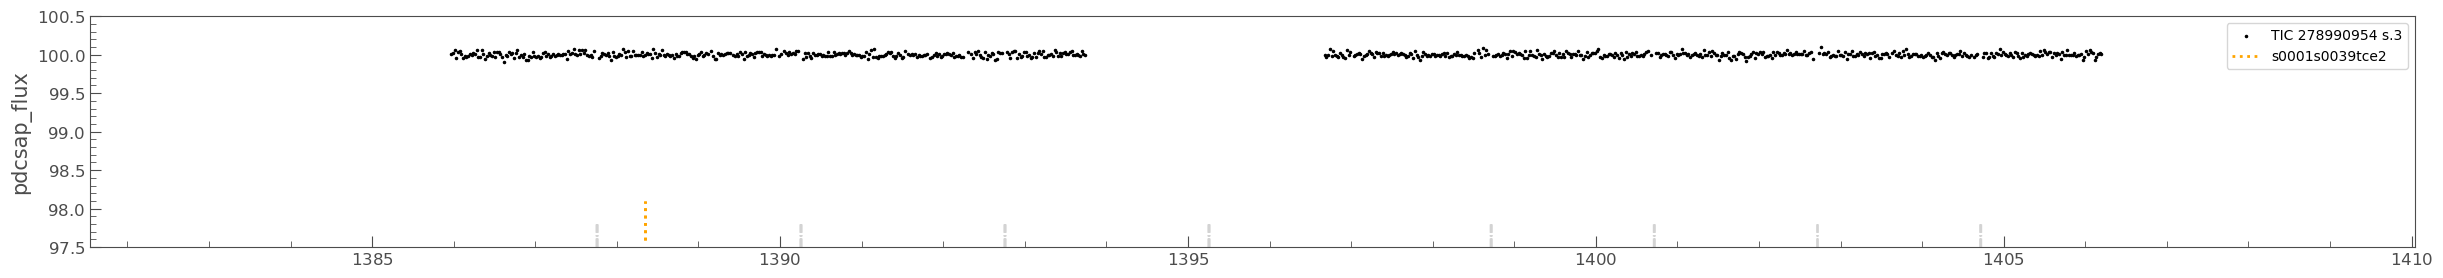

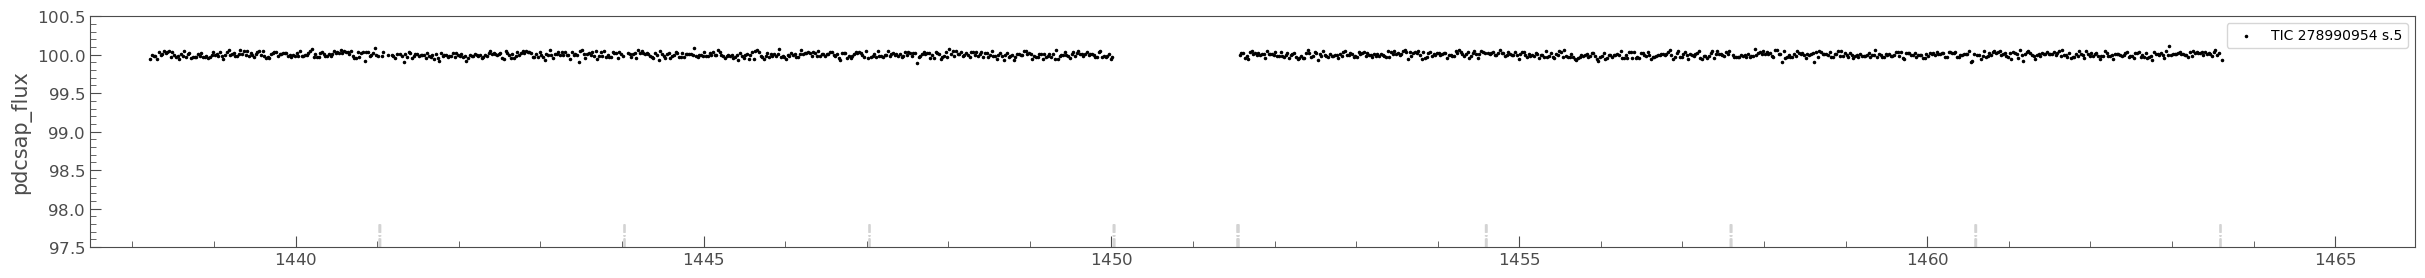

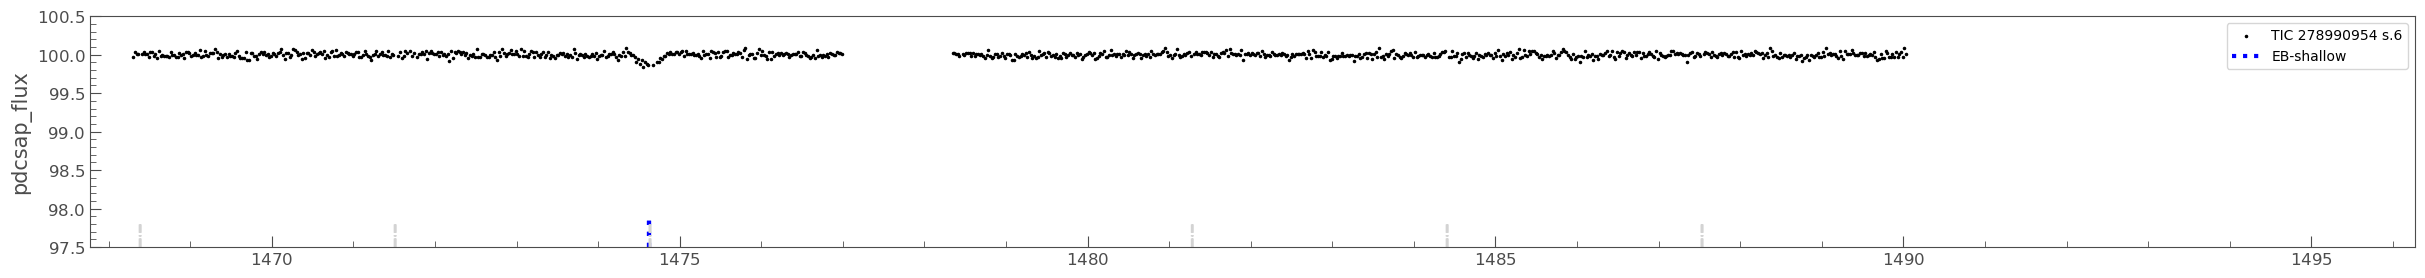

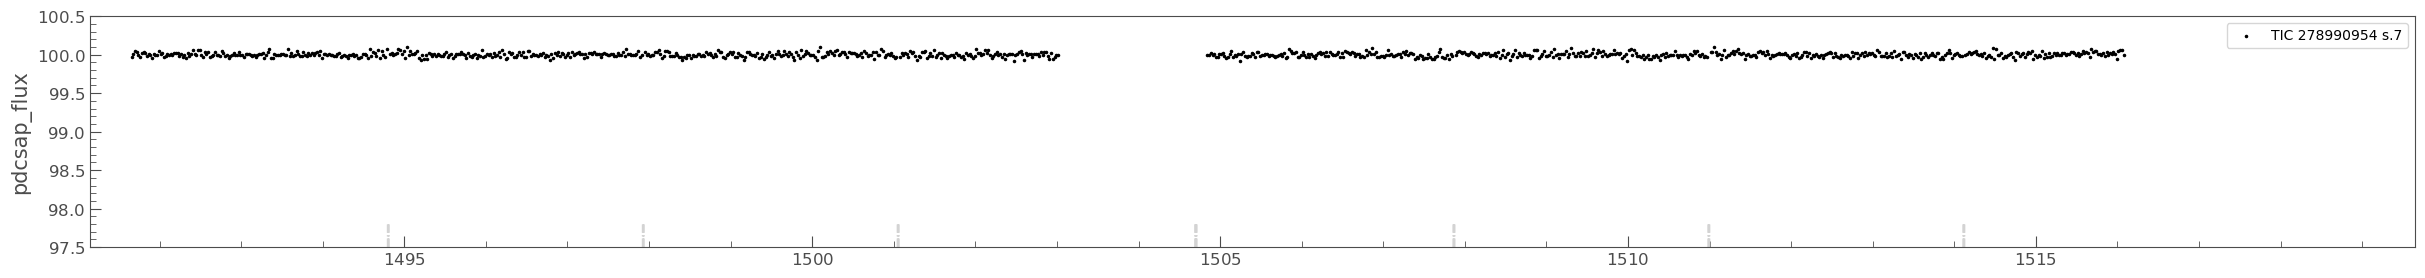

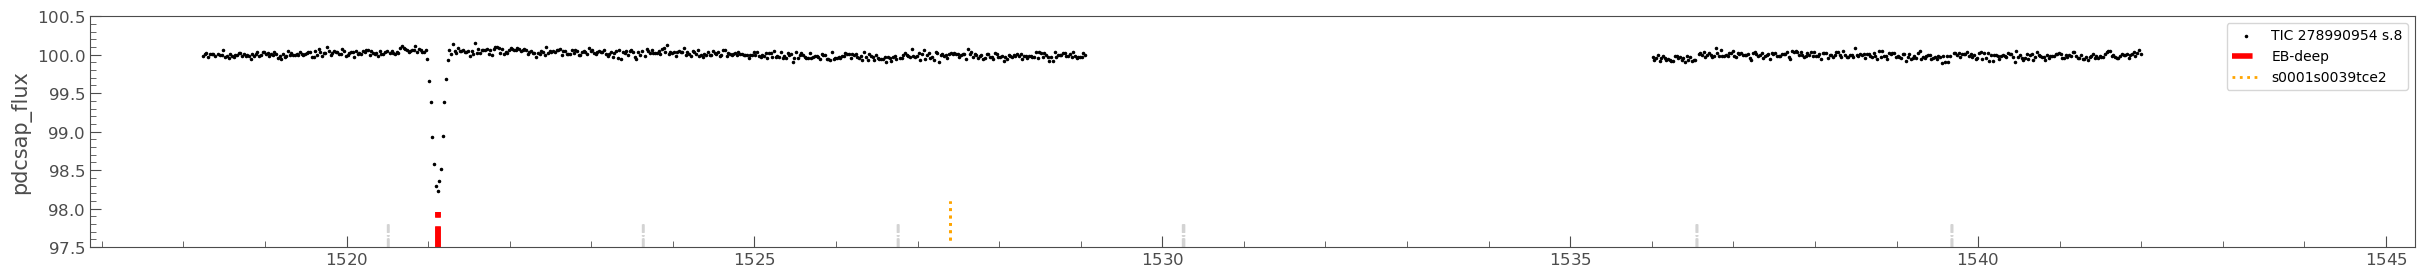

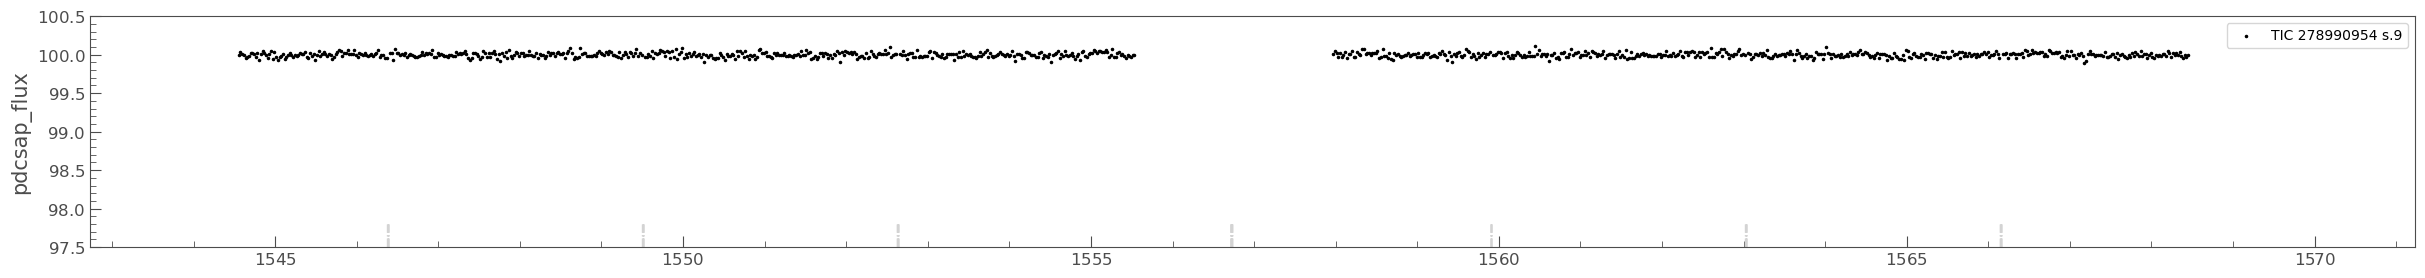

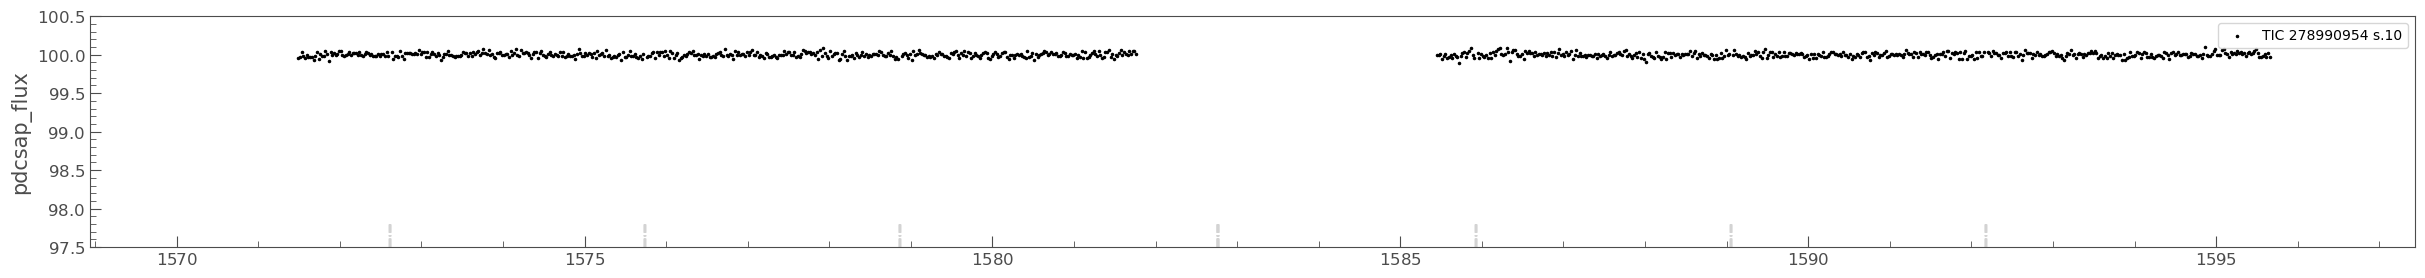

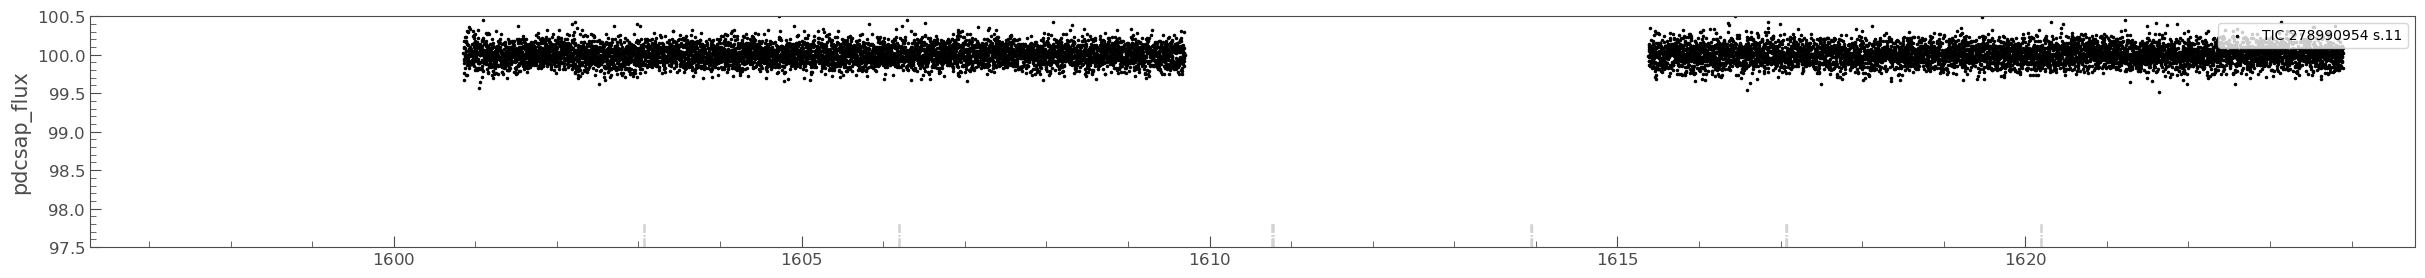

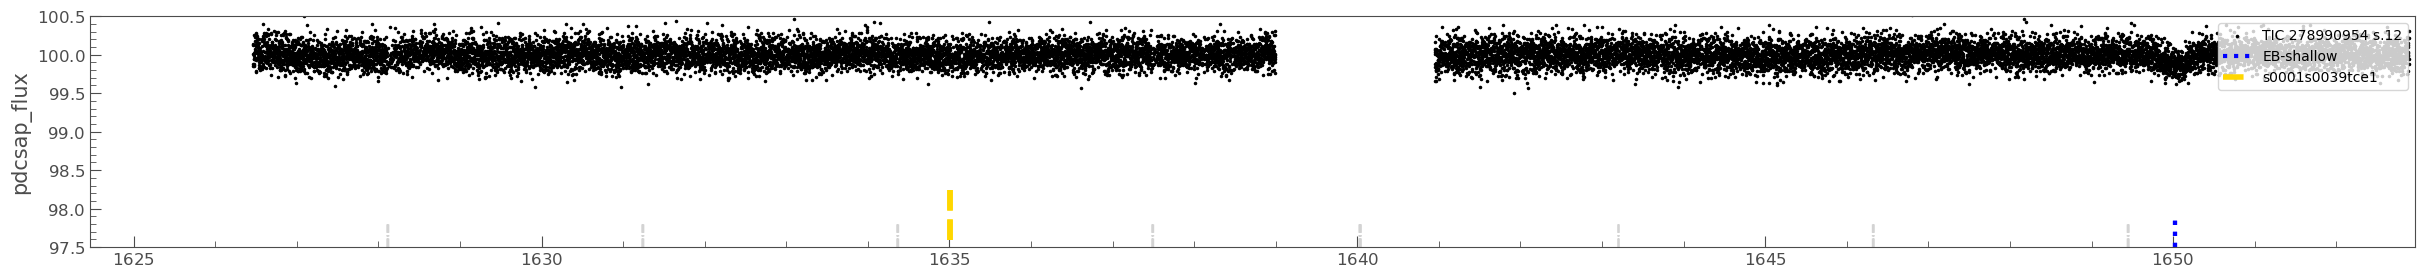

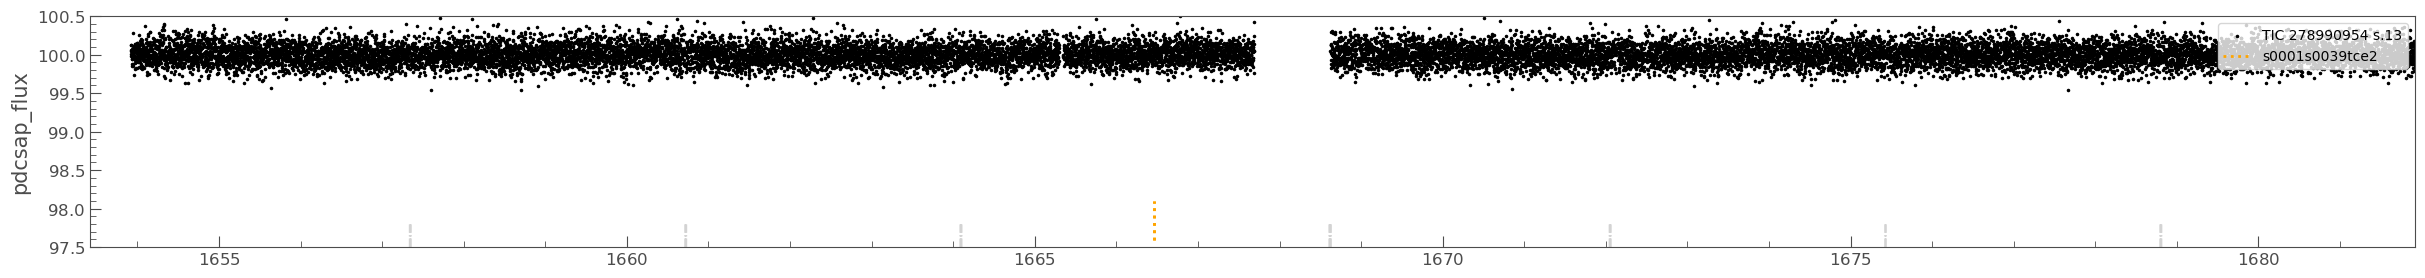

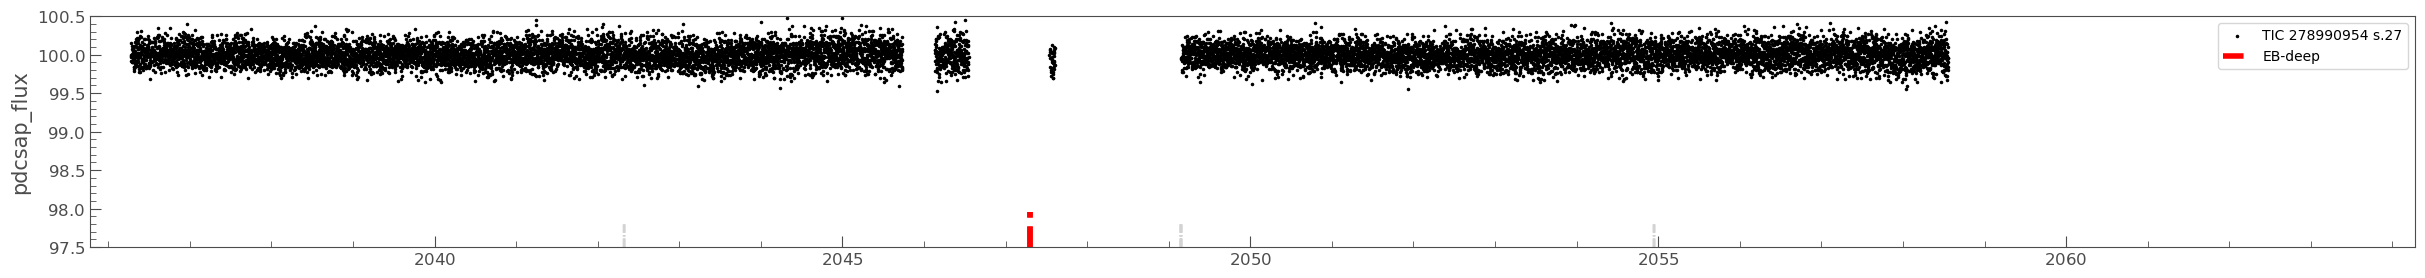

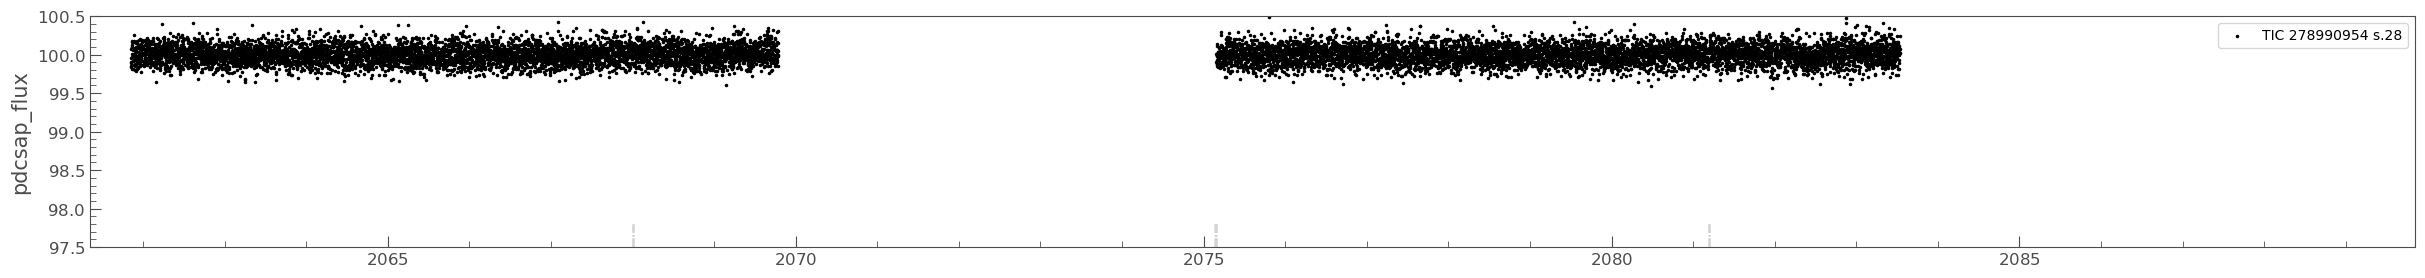

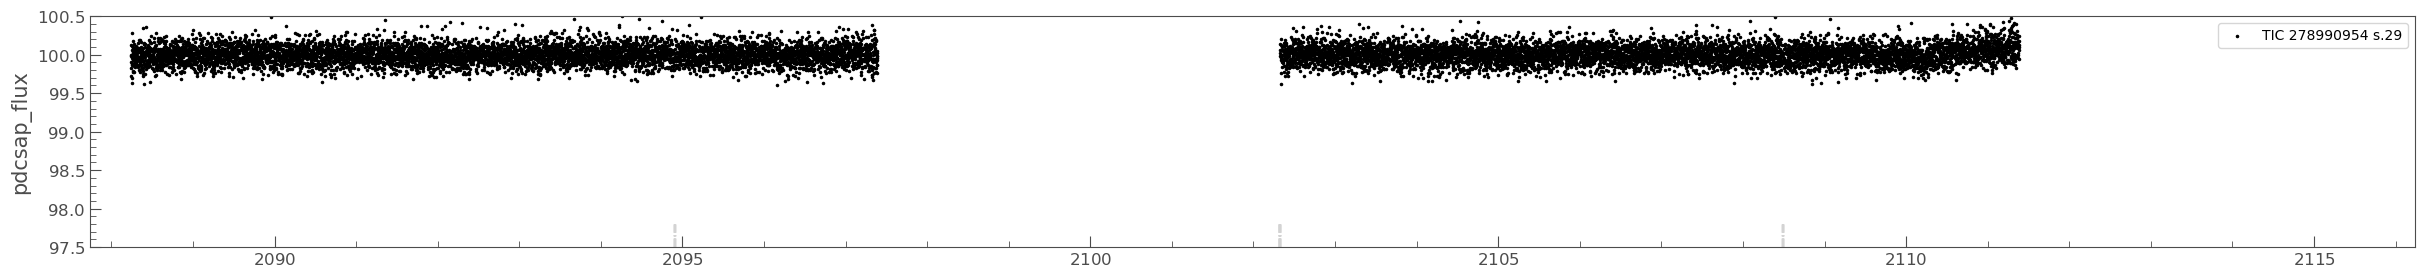

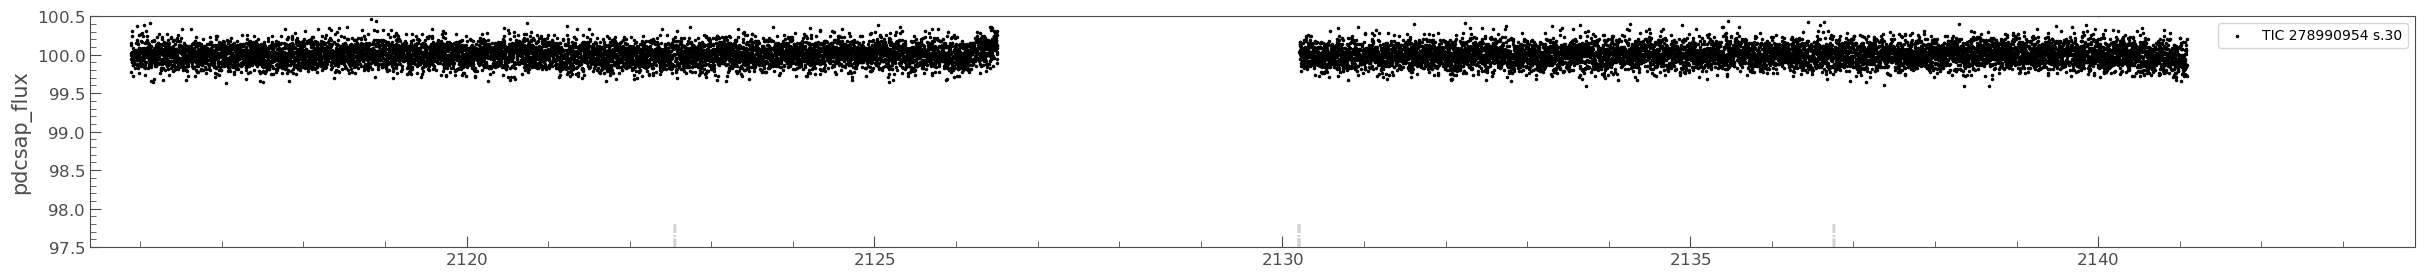

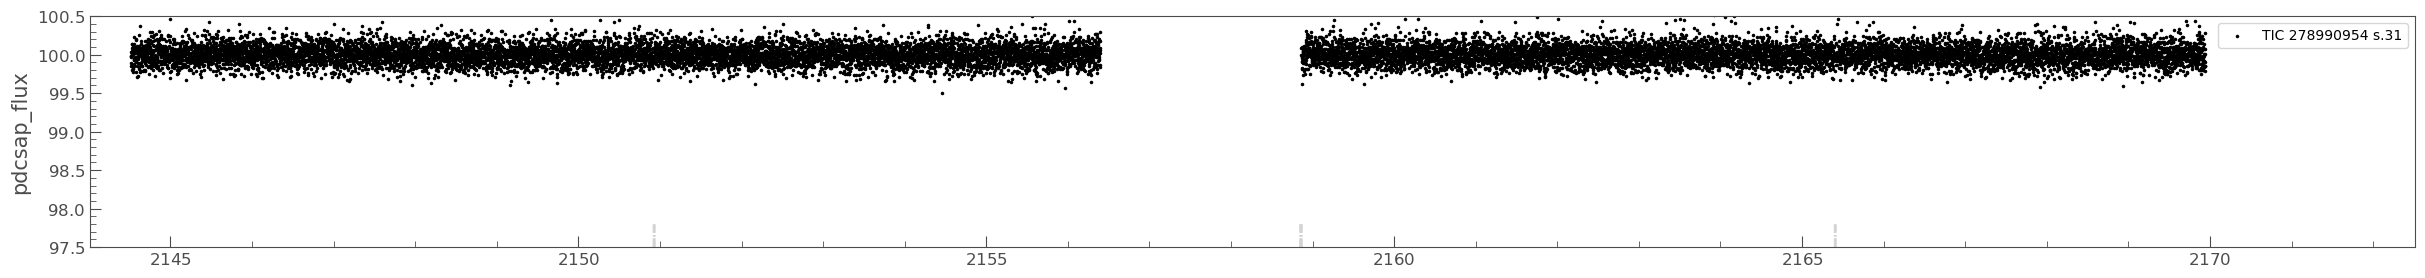

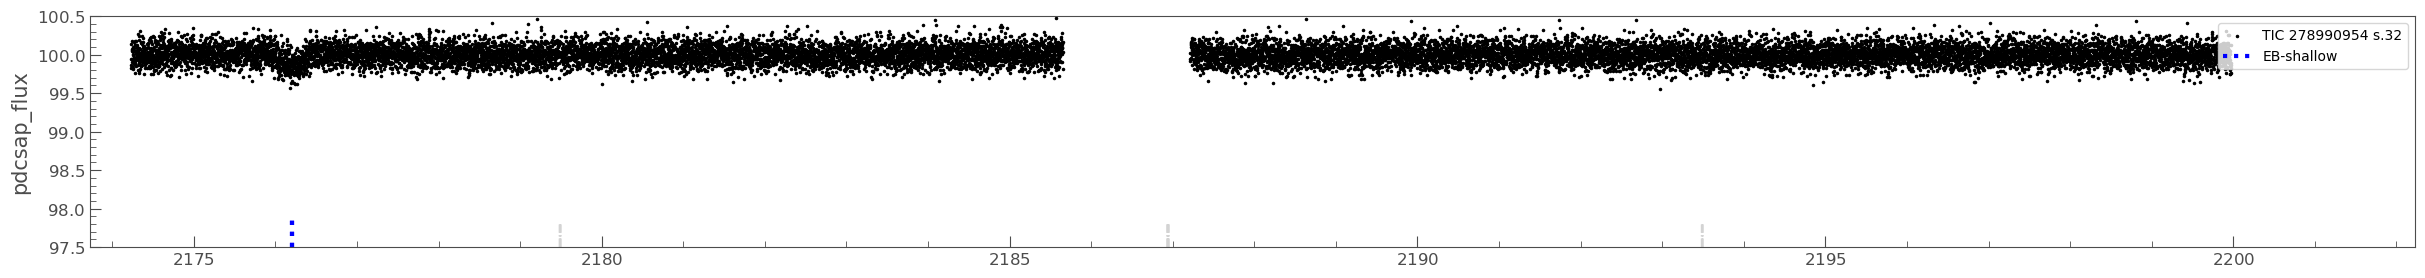

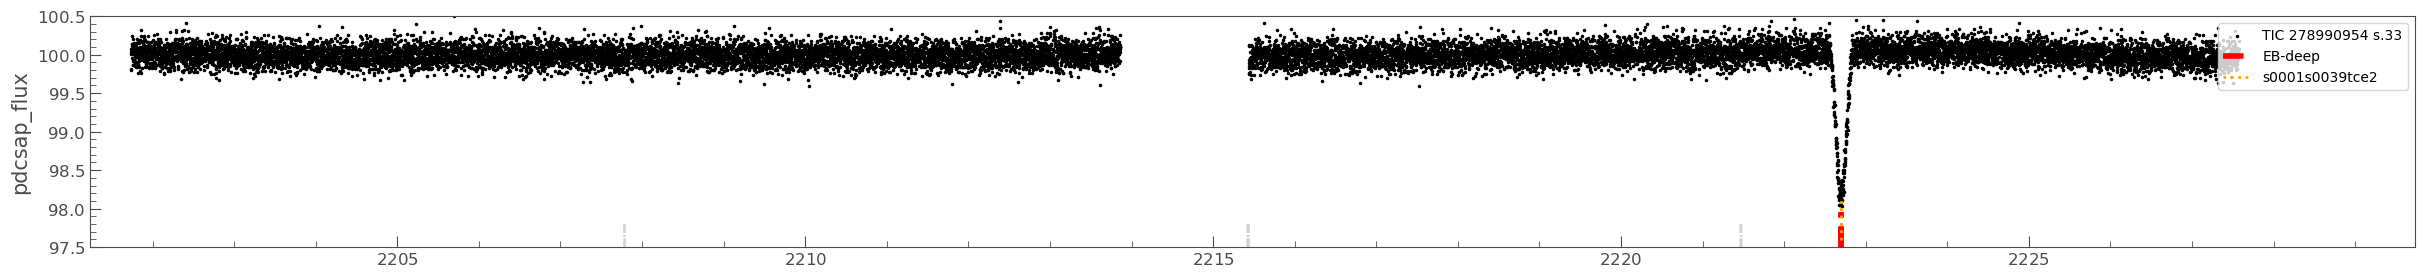

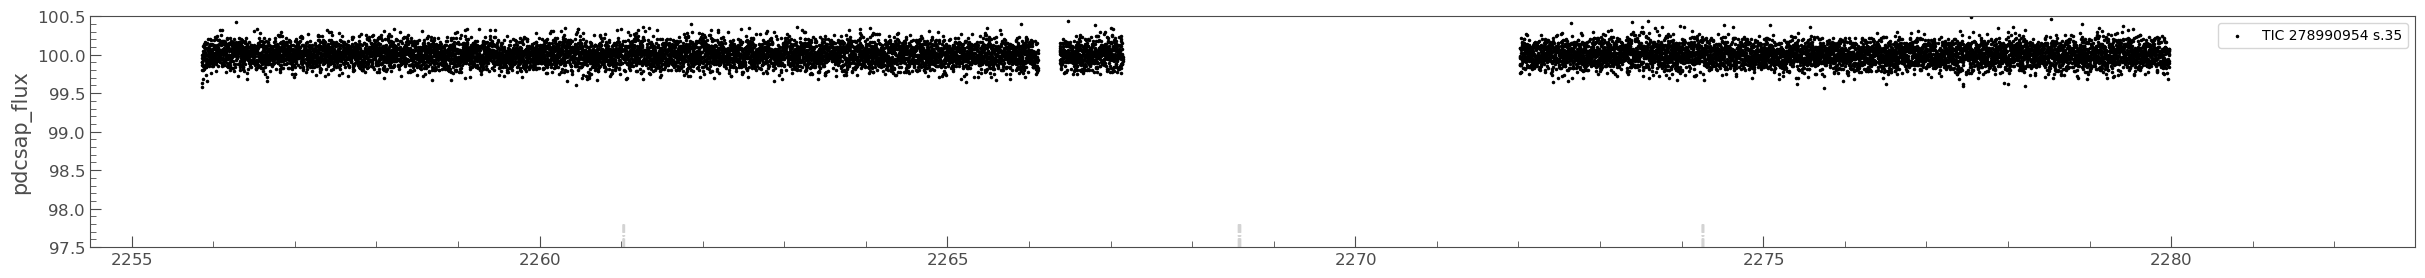

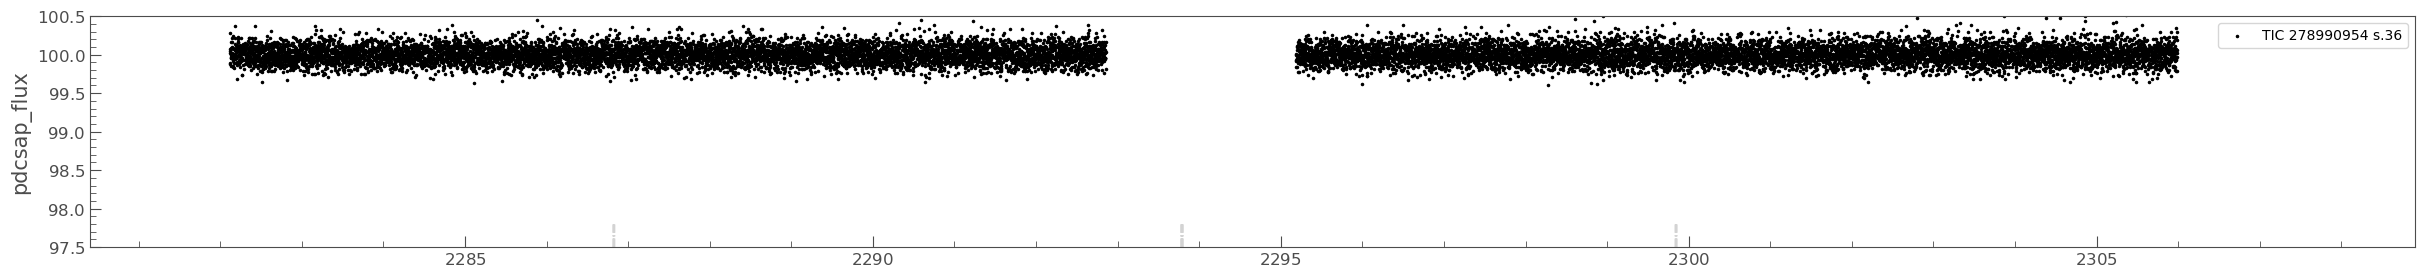

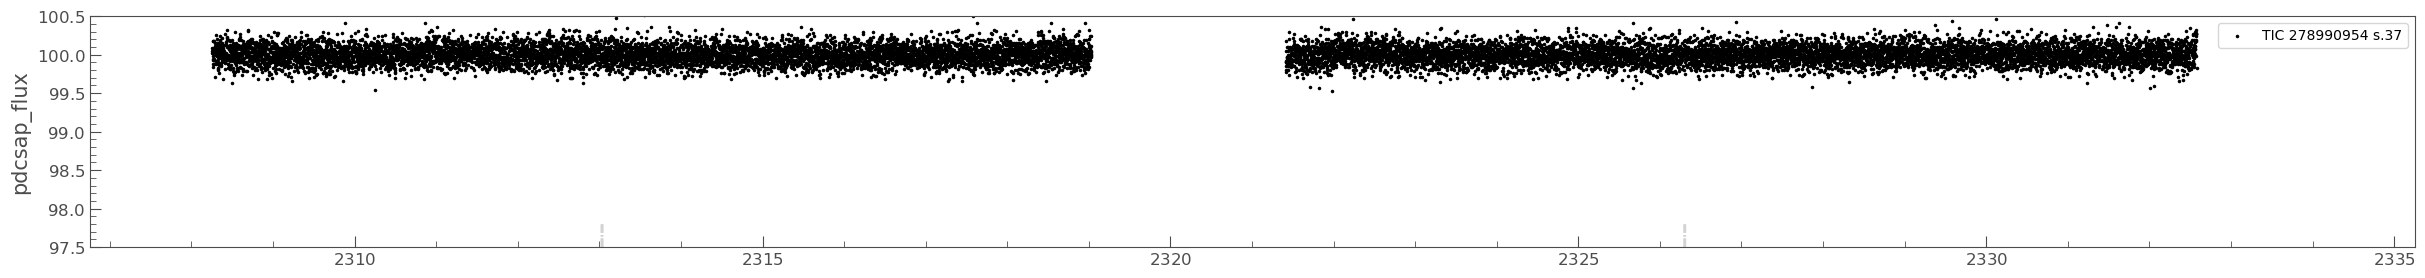

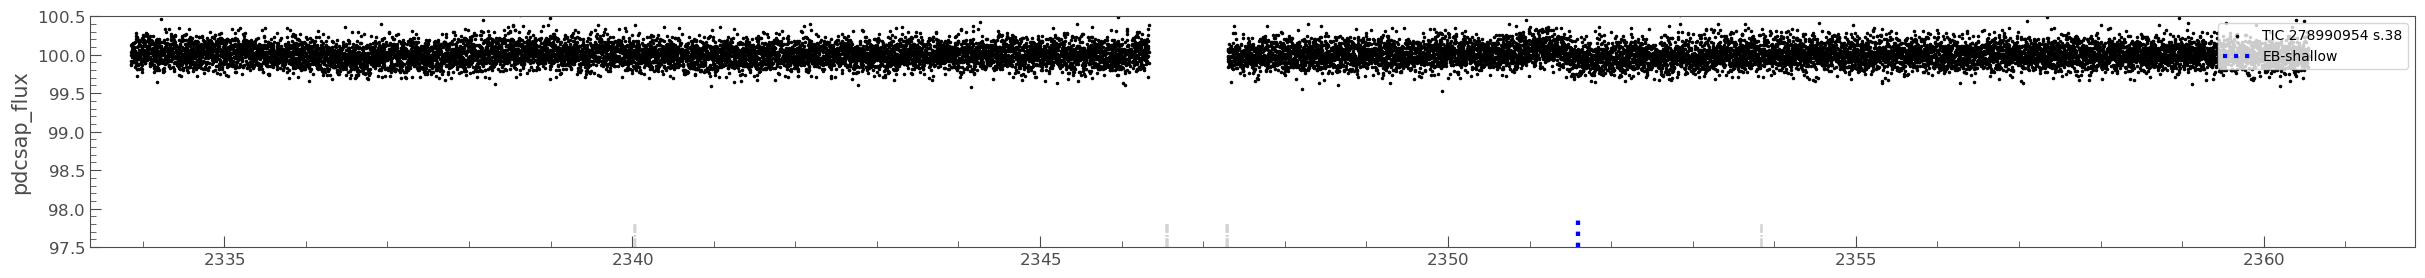

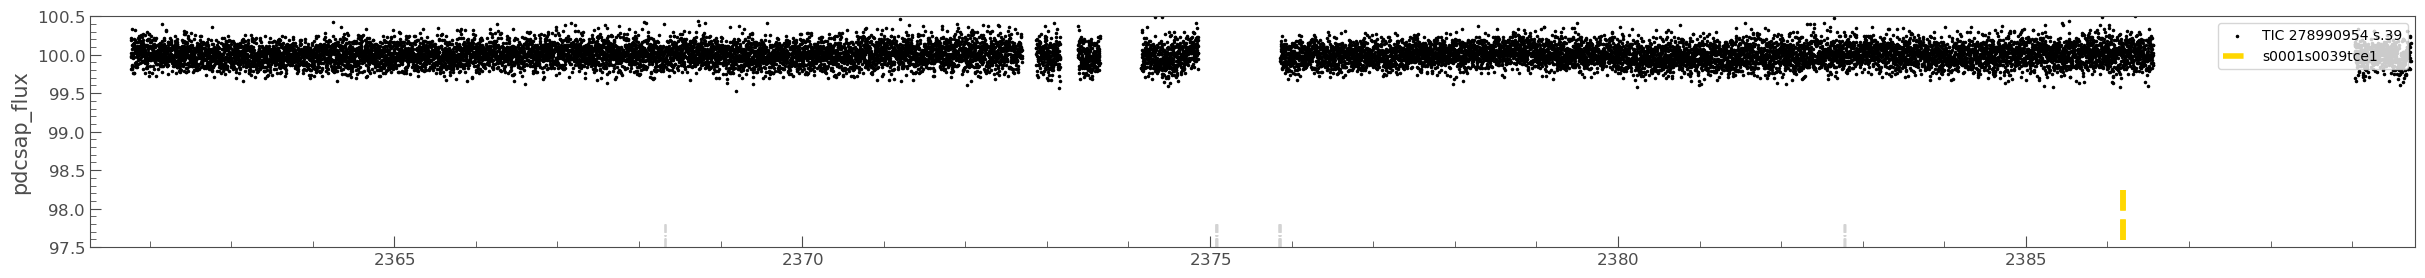

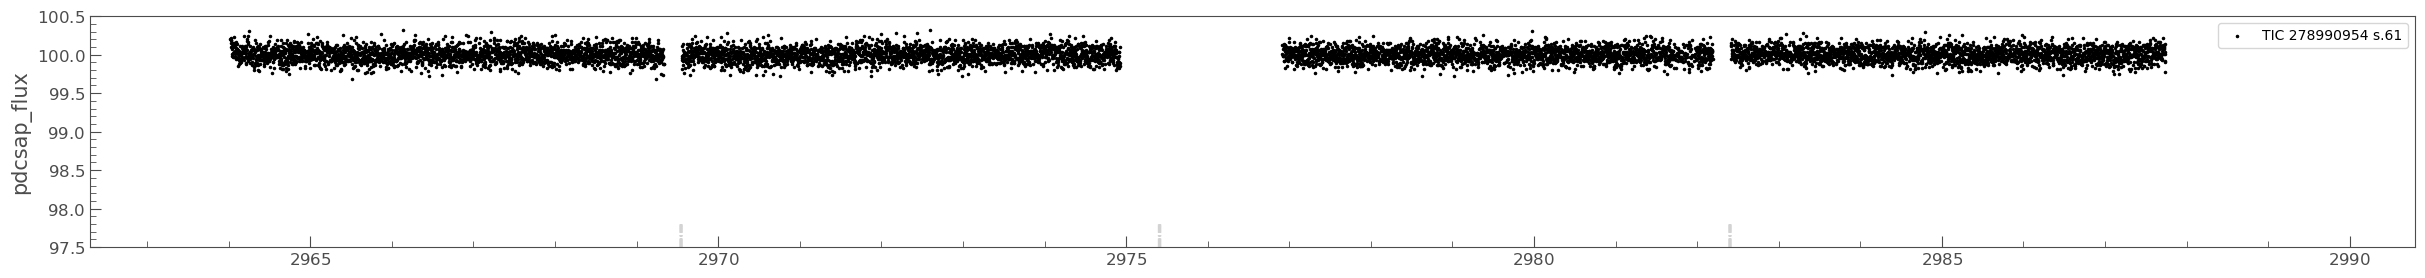

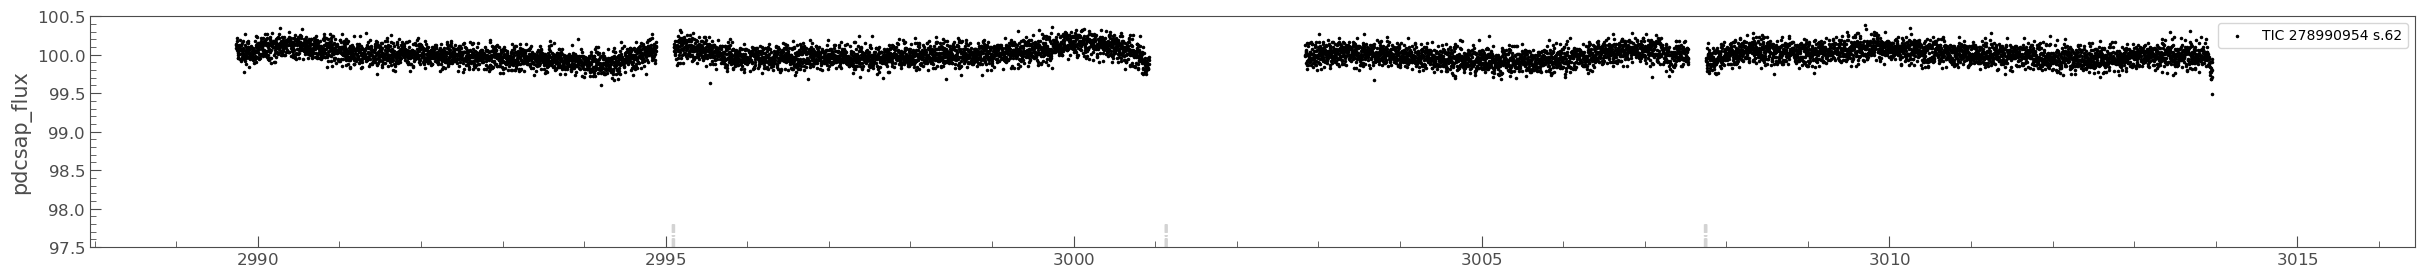

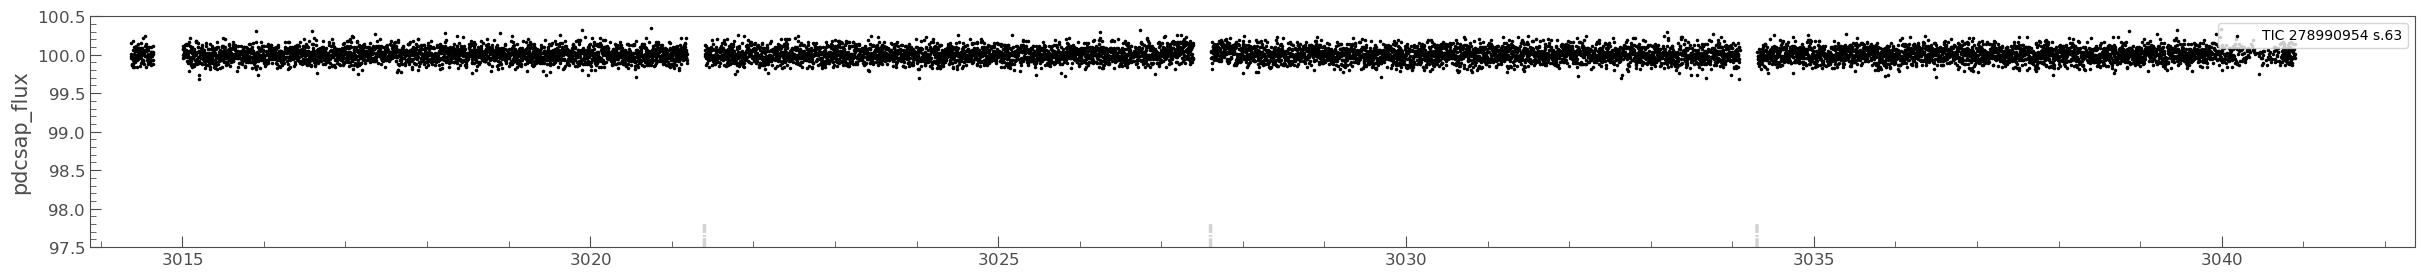

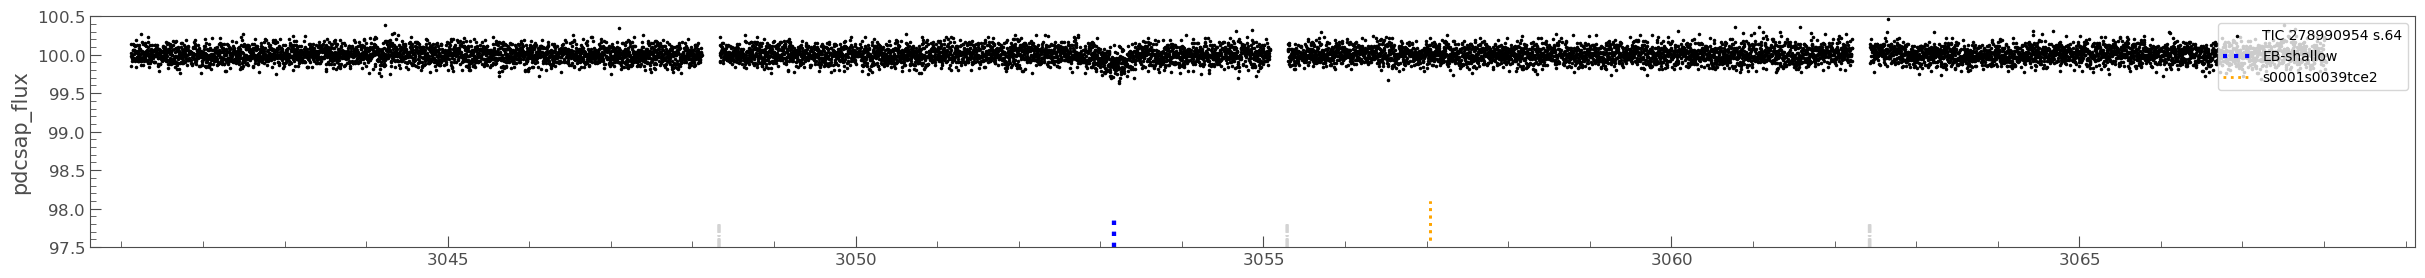

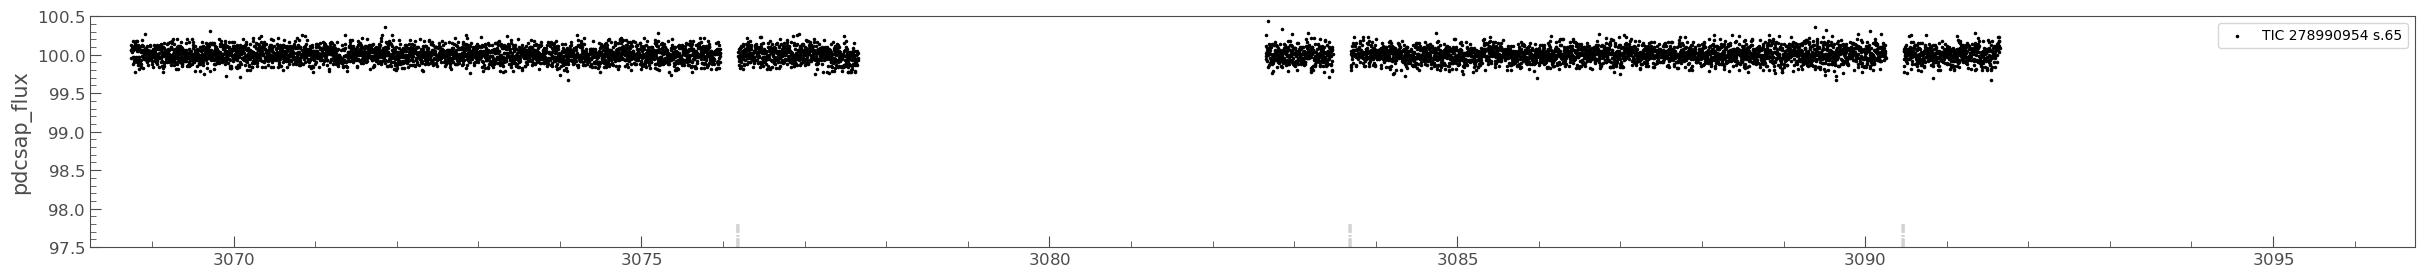

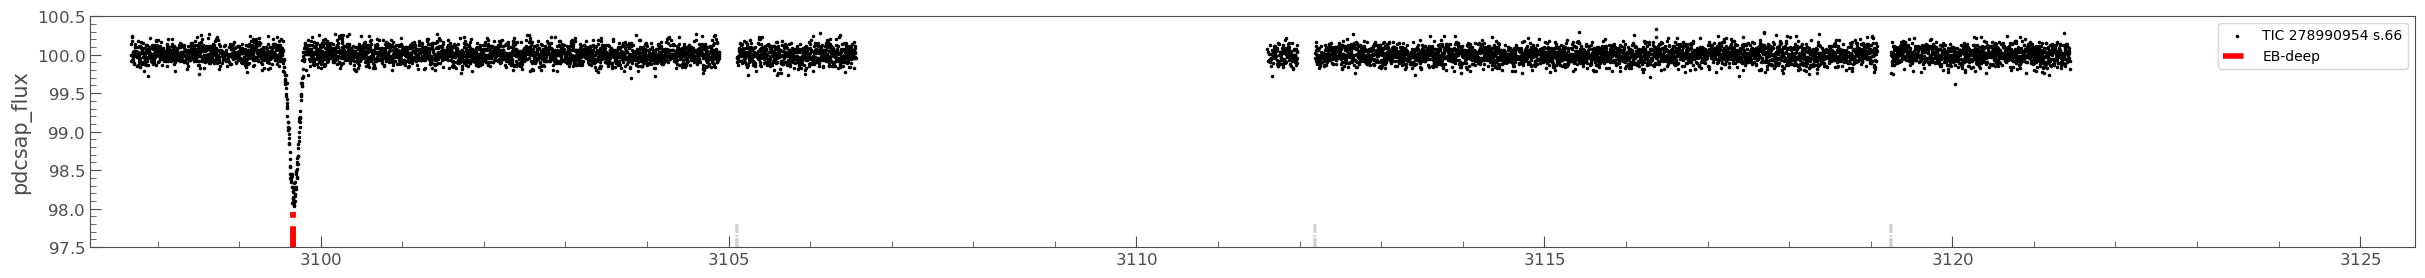

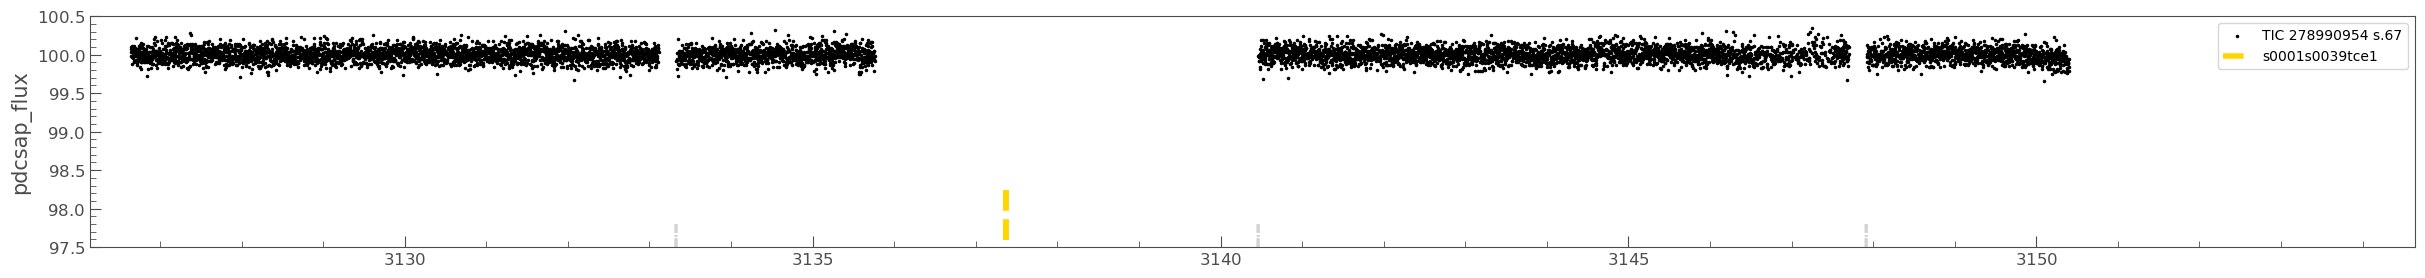

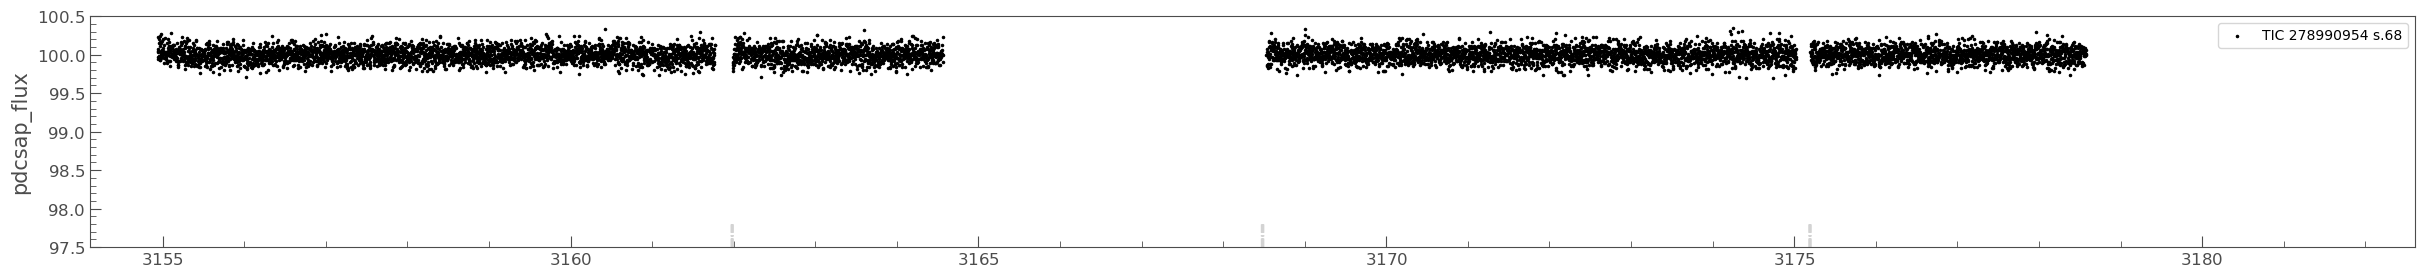

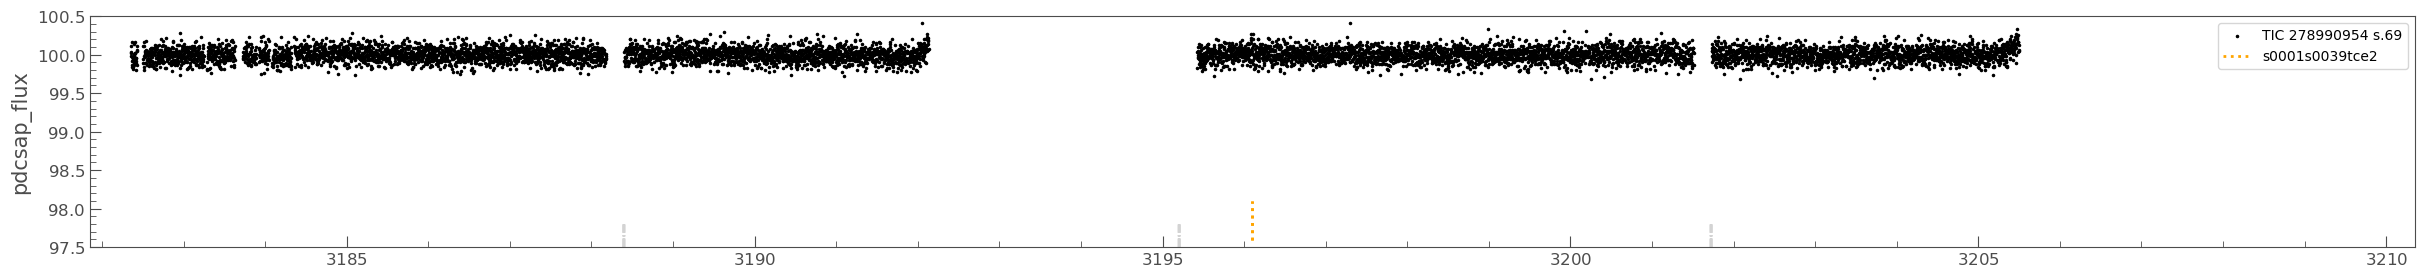

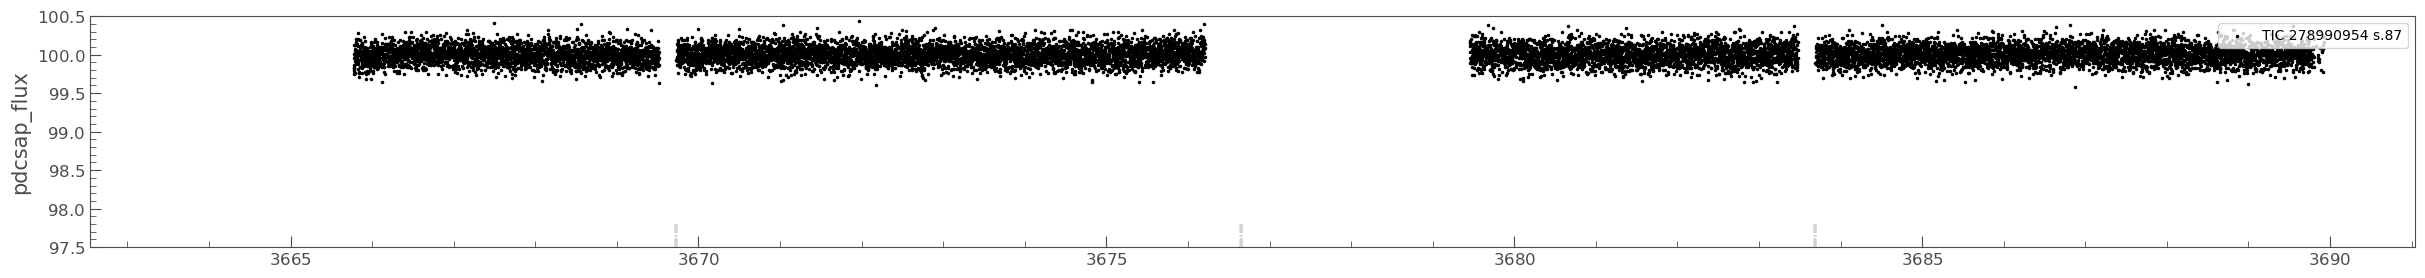

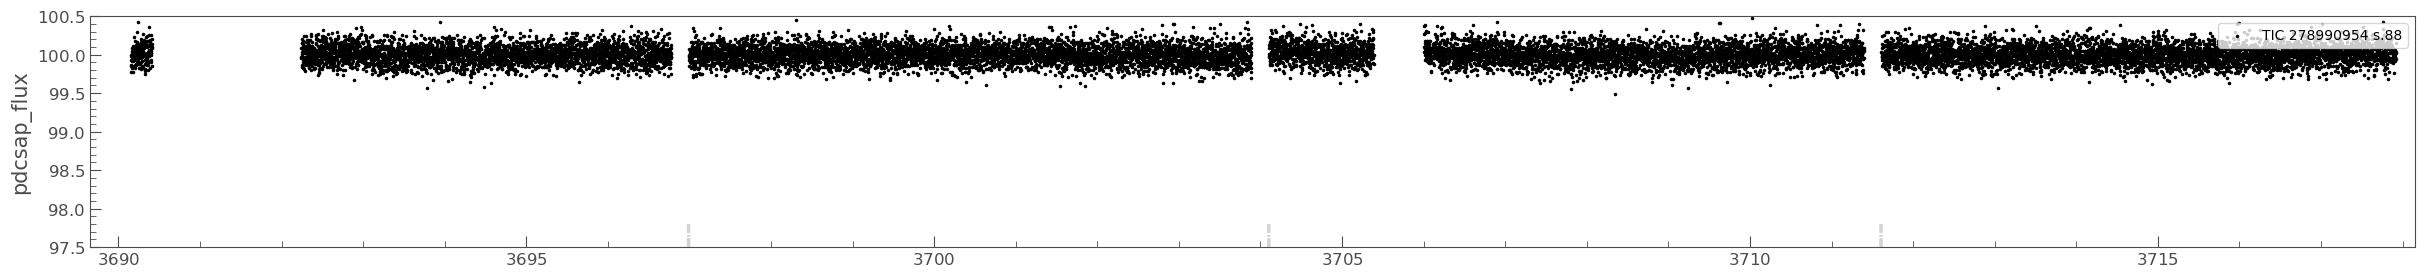

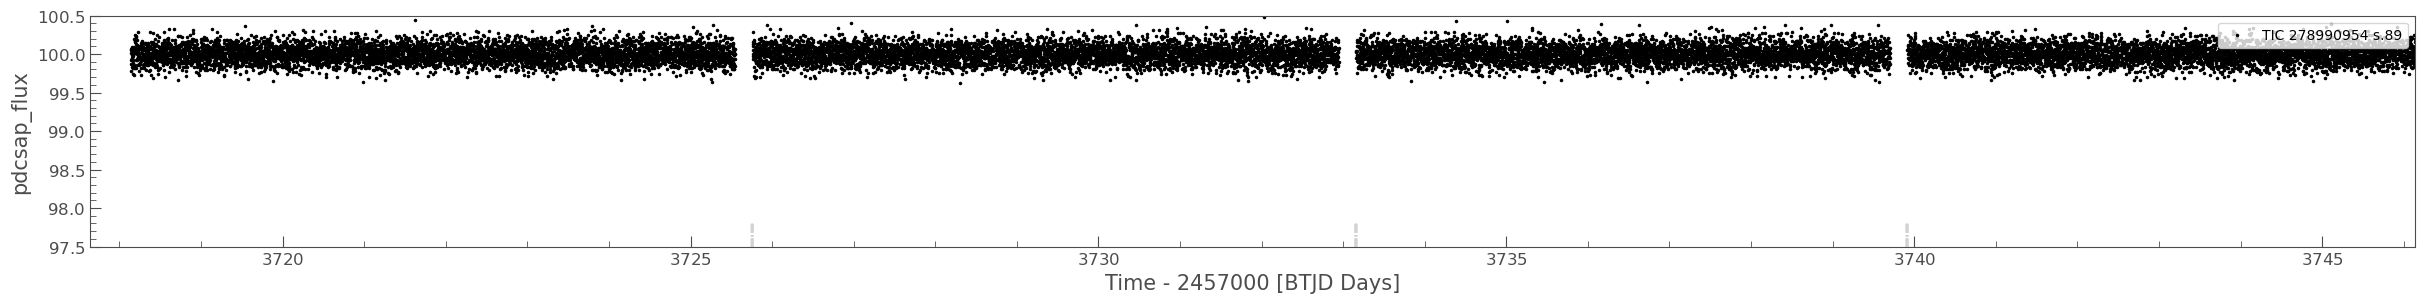

In [230]:
# plot transit times for a list of sectors, not just one

%matplotlib inline


red_marks = dict(linestyle='--', color="red", ymax=0.15, linewidth=4)
blue_marks = dict(linestyle=':', color="blue", ymax=0.12, linewidth=3)   # linewidth=3
yellow_marks = dict(linestyle='--', color="gold", ymin=0.03, ymax=0.25, linewidth=4)  # , ymax=0.5
orange_marks = dict(linestyle=':', color="orange", ymin=0.03, ymax=0.2, linewidth=2)  # , ymax=0.8
green_marks = dict(linestyle='--', color="green", ymin=0.15, ymax=0.40, linewidth=3)  # , ymax=0.8
purple_marks = dict(linestyle=':', color="purple", ymax=0.4)  # , ymax=0.5

# customize these parameters if needed
lcf_coll_to_use = of_sectors(lcc_tess_c, )  #  , sector

tt_specs = TransitTimeSpecList(  #
    dict(epoch=1521.12, duration_hr=6.5, period=175.394, label="EB-deep",
         sector=8, steps_to_show=[0],
    ),
    dict(epoch=1650.02, duration_hr=9, period=175.394, label="EB-shallow",
         sector=12, steps_to_show=[0],
    ),
    # to confirm the top TCEs are not helpful
    dict(epoch=1635.01, duration_hr=6.0, period=375.591, label="s0001s0039tce1", transit_depth_percent=3.1977,
    ),
    dict(epoch=1666.46, duration_hr=5.70905, period=139.058, label="s0001s0039tce2", transit_depth_percent=1.8298,
    ),
)


plot_kwargs = dict(
    s=9.5,  # 0.5, 
    # color="green",
)

axvline_kwargs_specs = [
    red_marks,
    blue_marks,
    yellow_marks,
    orange_marks,
    green_marks,
    purple_marks,    
]
skip_no_transit_plot = False  # True  # False
mark_data_gap = True
legend_loc = "upper right"  # "upper center", None

zoom_to_transit, figsize, plot_date_start, plot_date_range = False, (30, 3), -0.5, 28.5  # None, None,  (20, 4), (10, 2)

def tweak_axs(axs, ax_lcs):
    """Tweak the plots as a whole after all are plot, e.g., to set consistent global scale"""
    # generic tweaks 
    [ax.set_xlabel("") for i, ax in enumerate(axs) if i < len(axs) - 1];  # save vertical space: hide xlabel for all but the last plot 
    [ax.set_xlabel("Time - 2457000 [BTJD Days]") for i, ax in enumerate(axs) if i == len(axs) - 1];  # save vertical space: hide xlabel for all but the last plot 
    [ax.set_ylabel(ax.get_ylabel().replace("Normalized ", "")) for i, ax in enumerate(axs) if True];  # save vertical space: abbreivate ylabel
    [tplt.plot_momentum_dumps(lc, ax, color="lightgray", mark_height_scale=0.10) for ax, lc in zip(axs, ax_lcs)];

     # specific one-off-ish tweaks
    display(HTML("""<span style="background-color: yellow; font-size: 1.5em;">Note:</span> tweaking the plots..."""))
    [ax.set_ylim(97.5, 100.5) for i, ax in enumerate(axs) if True];
    # [ax.set_ylim(99.0, 100.5) for i, ax in enumerate(axs) if True];  # to highlight shallow dips
    # [ax.set_ylim(axs[-1].get_ylim()) for ax in axs];
    return None


def tweak_lcc(lcc):
    """Tweak the LC Collection to be used to plot / identify dips."""
    if True:  # no tweak, use PDCSAP_FLUX
        return lcc
    
    display(HTML("""<span style="background-color: orange; font-size: 1.5em;">Note:</span> tweak LC Collection source..."""))
    _specs = None  # don't mask dips
    # _specs = TransitTimeSpecList(*transit_specs[0:1])  # transit_specs
    duration_factor = 1.2  # mask oout some oot cadence to ensure variation due to transits/eclipses are masked
    if _specs is not None:
        display(HTML("""<b style="background-color: orange;">Note:</b> Dips are masked."""))
    def tweak_lc(lc):
        # lc = lc.select_flux("cal_aper_flux")  # TGLC
        lc = lke.select_flux(lc, ["sap_flux"]) # to get maximum cadences in plot
        if _specs is not None:
            tmask = lc.create_transit_mask(transit_time=_specs.epoch, period=_specs.period, duration=_specs.duration * duration_factor)
            lc = lc[~tmask]
        # if lc.author == 'Kepler':
        #     print("DBG K2 LC time format", lc.time.format)              
        # lc = lc.remove_outliers(sigma=5)
        return lc
    
    return lk.LightCurveCollection([tweak_lc(lc) for lc in lcc])


def tweak_ax_with_lc(ax, lc):
    """Tweak the individual plot, the lc is supplied for informational purpose"""
#     display(HTML("""<span style="background-color: yellow">Note:</span> tweaking indiviual plot..."""))    
    return


# the plot transit time logic
#
lcc_tweaked = tweak_lcc(lcf_coll_to_use)
ax_lcs, axs, tt_lists = [], [], []
for lc_to_use in lcc_tweaked:
    with warnings.catch_warnings():
        # avoid warnings about repeated normalization
        warnings.filterwarnings("ignore", category=lk.LightkurveWarning, message=".*in relative units.*")
        lc_to_use = lke.normalize(lc_to_use.remove_nans(), unit="percent")
    ax = tplt.lk_ax(figsize=figsize)
    ax1, tt_list = tplt.mark_transit_times(lc_to_use, tt_specs,
                                           axvline_kwargs_specs=axvline_kwargs_specs,
                                           plot_kwargs=plot_kwargs,
                                           ax=ax,
                                           skip_no_transit_plot=skip_no_transit_plot,
                                           mark_data_gap=mark_data_gap,
                                           legend_loc=legend_loc,                                       
                                          )
    
    if ax1 is not None:
        ax1.set_ylabel('Normalized ' + lc_to_use.meta['FLUX_ORIGIN'])
        if zoom_to_transit:
            if tt_list is not None:  # zoom in to the first transit of each sector
                t_midpoint = tt_list[specs_idx][step]
                ax1.set_xlim(t_midpoint - zoom_duration / 2, t_midpoint +  zoom_duration / 2)
                ax1.set_ylim(ymin, ymax)            
        else:  # regular no zoom case
            # make all plots to have consistent scale in x-axis, if user asks for it.
            if plot_date_start is not None and plot_date_range is not None:
                tstart = lc_to_use.meta.get("TSTART", lc_to_use.time.min().value)
                ax1.set_xlim(tstart + plot_date_start, tstart + plot_date_start + plot_date_range)
        if lc_to_use.meta.get("TSTART", None) is not None:
            ax1.set_xlabel(ax1.get_xlabel() + F" , TSTART={lc_to_use.tstart:.2f}")

        tweak_ax_with_lc(ax1, lc_to_use)  #user override
        ax_lcs.append(lc_to_use); axs.append(ax1), tt_lists.append(tt_list)
    else:
        plt.close(ax.figure)

# print(tt_specs);
# print(tt_lists);
# print out the transit  times nicely
for i, spec, in enumerate(tt_specs):
    print(i, spec.get("label", "None"))
    for tt_list_of_sector in tt_lists:
        # dips across all specs of a given sector
        if len(tt_list_of_sector[i]) > 0:
            print("   ", [round(t, 2) for t in tt_list_of_sector[i]])

tweak_axs(axs, ax_lcs);
# print("duration (hr)", (t_end - t_begin) * 24)


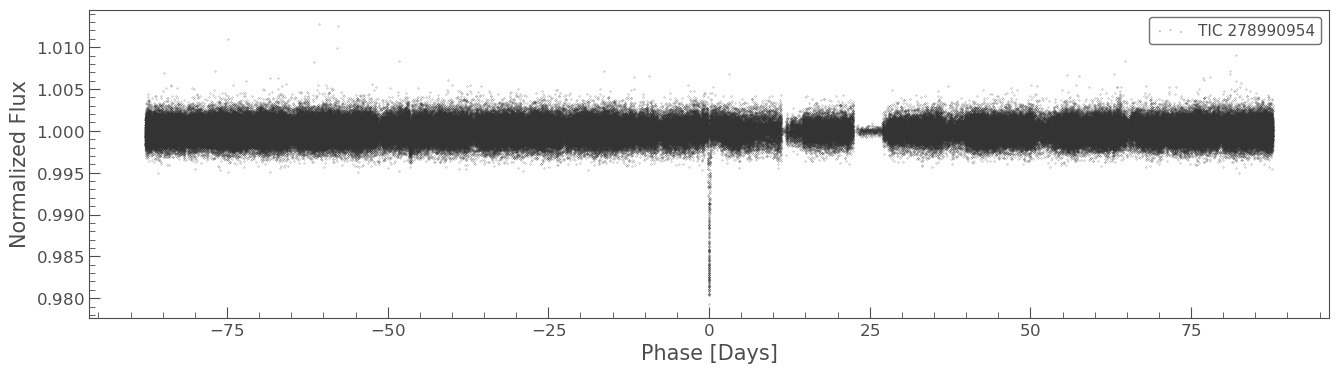

In [40]:
t0, period = tt_specs[0]["epoch"], tt_specs[0]["period"]

lc = lke.stitch(lcc_tess_c, ignore_incompatible_column_warning=True,)
lc_f = lc.fold(period=period, epoch_time=t0);
ax = tplt.scatter(lc_f, s=0.1, figsize=(16, 4));
# ax.set_ylim(0.5, 1.1);

### Inspect contamination at pixel level

In [35]:
# get a sector with a deep dip
tpf_c = lk.search_targetpixelfile(f"TIC{tic_contaminant}", sector=33)[0].download()  # use the contaminat, as it has background-subtracted tpf
tpf_c


TessTargetPixelFile(TICID: 278990954)

In [36]:
magnitude_limit = 18
catalogs = ["gaiadr3_tic", "skypatrol2", "ztf", "vsx", ]

import tpf_webapp
from tpf_webapp import main as tpfm

tpfm.show_in_notebook_app_body_ui_from_tpf(
    tpf_c, catalogs=catalogs, magnitude_limit=magnitude_limit,
    notebook_url=notebook_url,
)

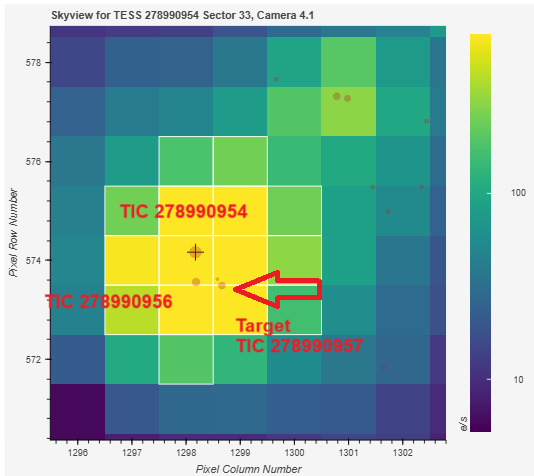

Around a deep eclipse:

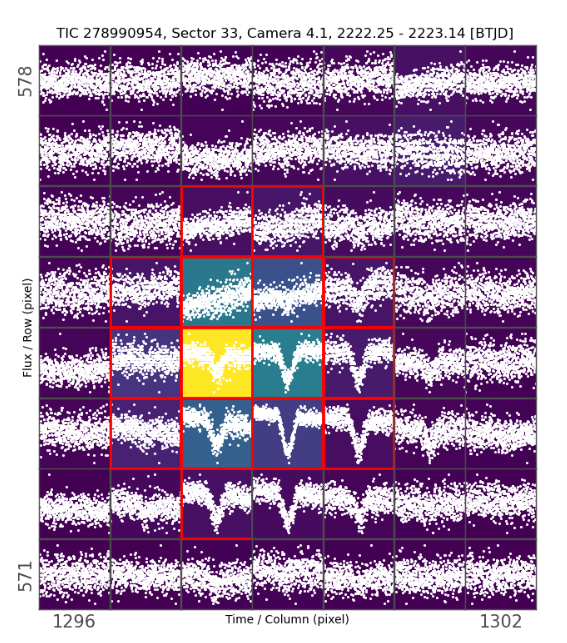


- SPOC [S01-39TCE2](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC278990954S0001S0039TCE2) for TIC 278990954 suggests TIC 278990957 is the source
  - Note: the TCE2 has incorrect epoch/period, but it does capture the deep eclipse in sector 33 at BTJD 2222.7

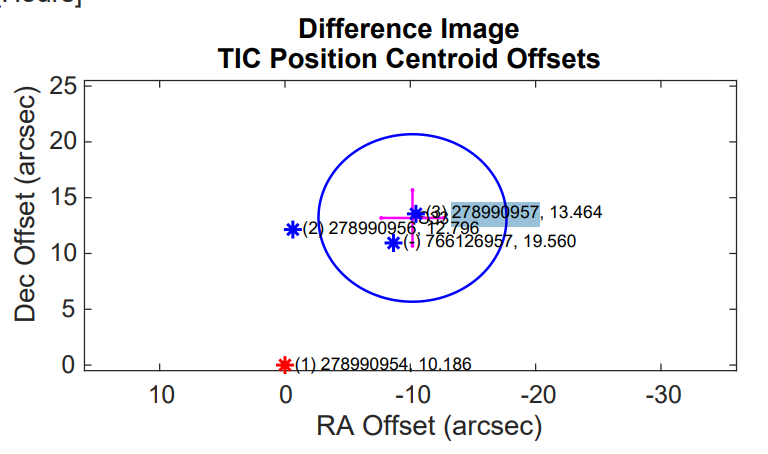

---

- My centroid analysis also suggests TIC 278990957 is the source


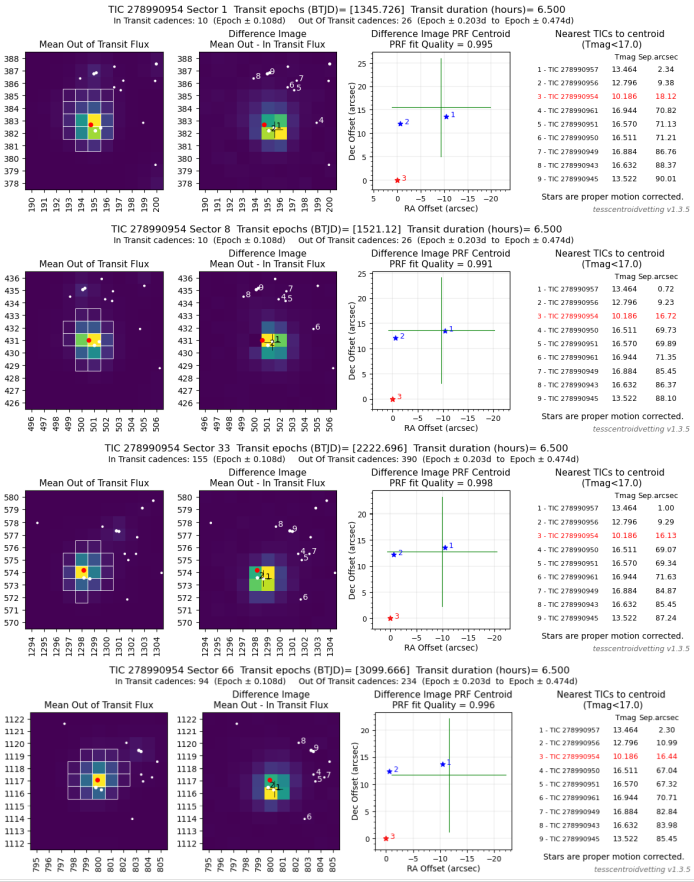


### TESS data of the target

In [83]:
tic = 278990957

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["QLP", "SPOC", "TESS-SPOC", "TGLC", "GSFC-ELENAOR-LITE"])
sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 35 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 01 2018    QLP    1800   278990957      0.0         N/A
  1 TESS Sector 02 2018    QLP    1800   278990957      0.0         N/A
  2 TESS Sector 05 2018    QLP    1800   278990957      0.0         N/A
  3 TESS Sector 06 2018    QLP    1800   278990957      0.0         N/A
  4 TESS Sector 07 2019    QLP    1800   278990957      0.0         N/A
  5 TESS Sector 08 2019    QLP    1800   278990957      0.0         N/A
  6 TESS Sector 09 2019    QLP    1800   278990957      0.0         N/A
  7 TESS Sector 10 2019    QLP    1800   278990957      0.0         N/A
  8 TESS Sector 11 2019    QLP    1800   278990957      0.0         N/A
  9 TESS Sector 12 2019    QLP    1800   278990957      0.0         N/A
 10 TESS Sector 13 2019    QLP    1800   278990957      0.0         N/A
 11 TESS Sector 27 2020    QLP     600   278990957      0.0         N/A
 12 TESS Sector 28 2020    QLP     600   278990957      0.0         N/A
 13 TESS Sector 29 2020    QLP     600   278990957      0.0         N/A
 14 TESS Sector 30 2020    QLP     600   278990957      0.0         N/A
 15 TESS Sector 31 2020    QLP     600   278990957      0.0         N/A
 16 TESS Sector 32 2020    QLP     600   278990957      0.0         N/A
 17 TESS Sector 33 2020    QLP     600   278990957      0.0         N/A
 18 TESS Sector 35 2021    QLP     600   278990957      0.0         N/A
 19 TESS Sector 36 2021    QLP     600   278990957      0.0         N/A
 20 TESS Sector 37 2021    QLP     600   278990957      0.0         N/A
 21 TESS Sector 38 2021    QLP     600   278990957      0.0         N/A
 22 TESS Sector 39 2021    QLP     600   278990957      0.0         N/A
 23 TESS Sector 61 2023    QLP     200   278990957      0.0         N/A
 24 TESS Sector 62 2023    QLP     200   278990957      0.0         N/A
 25 TESS Sector 63 2023    QLP     200   278990957      0.0         N/A
 26 TESS Sector 64 2023    QLP     200   278990957      0.0         N/A
 27 TESS Sector 65 2023    QLP     200   278990957      0.0         N/A
 28 TESS Sector 66 2023    QLP     200   278990957      0.0         N/A
 29 TESS Sector 67 2023    QLP     200   278990957      0.0         N/A
 30 TESS Sector 68 2023    QLP     200   278990957      0.0         N/A
 31 TESS Sector 69 2023    QLP     200   278990957      0.0         N/A
 32 TESS Sector 87 2024    QLP     200   278990957      0.0         N/A
 33 TESS Sector 88 2025    QLP     200   278990957      0.0         N/A
 34 TESS Sector 89 2025    QLP     200   278990957      0.0         N/A

LightCurveCollection of 35 objects:
    0: <TessLightCurve LABEL="TIC 278990957" SECTOR=1 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 278990957" SECTOR=2 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    2: <TessLightCurve LABEL="TIC 278990957" SECTOR=5 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 278990957" SECTOR=6 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    4: <TessLightCurve LABEL="TIC 278990957" SECTOR=7 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    5: <TessLightCurve LABEL="TIC 278990957" SECTOR=8 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    6: <TessLightCurve LABEL="TIC 278990957" SECTOR=9 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    7: <TessLightCurve LABEL="TIC 278990957" SECTOR=10 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    8: <TessLightCurve LABEL="TIC 278990957" SECTOR=11 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    9: <TessLightCurve LABEL="TIC 278990957" SECTOR=12 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    10: <TessLightCurve LABEL="TIC 278990957" SECTOR=13 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
  

In [48]:
# Check QLP aperture
# section secton 2.3.2 (Lightcurve header) in https://arxiv.org/pdf/2011.06459 (Huang+ 2020)
# e.g, 2.5:4.0:3.0 means: aperture: 2.5 px radius, small scale annular background , 4.0px inner radius, 3..0 width  (see Lightcurve extraction section of the Huang+ 2020)
_lc = of_sector(lcc_tess, 8)
print("QLP: ", _lc.meta.get('BESTAP'), _lc.meta.get('SMALLAP'), _lc.meta.get('LARGEAP'))
_lc = of_sector(lcc_tess, 33)
print("QLP: ", _lc.meta.get('BESTAP'), _lc.meta.get('SMALLAP'), _lc.meta.get('LARGEAP'))

QLP:  2.5:4.0:3.0 1.75:4.0:3.0 3.0:4.0:3.0
QLP:  2.5:4.0:3.0 1.75:4.0:3.0 3.0:4.0:3.0


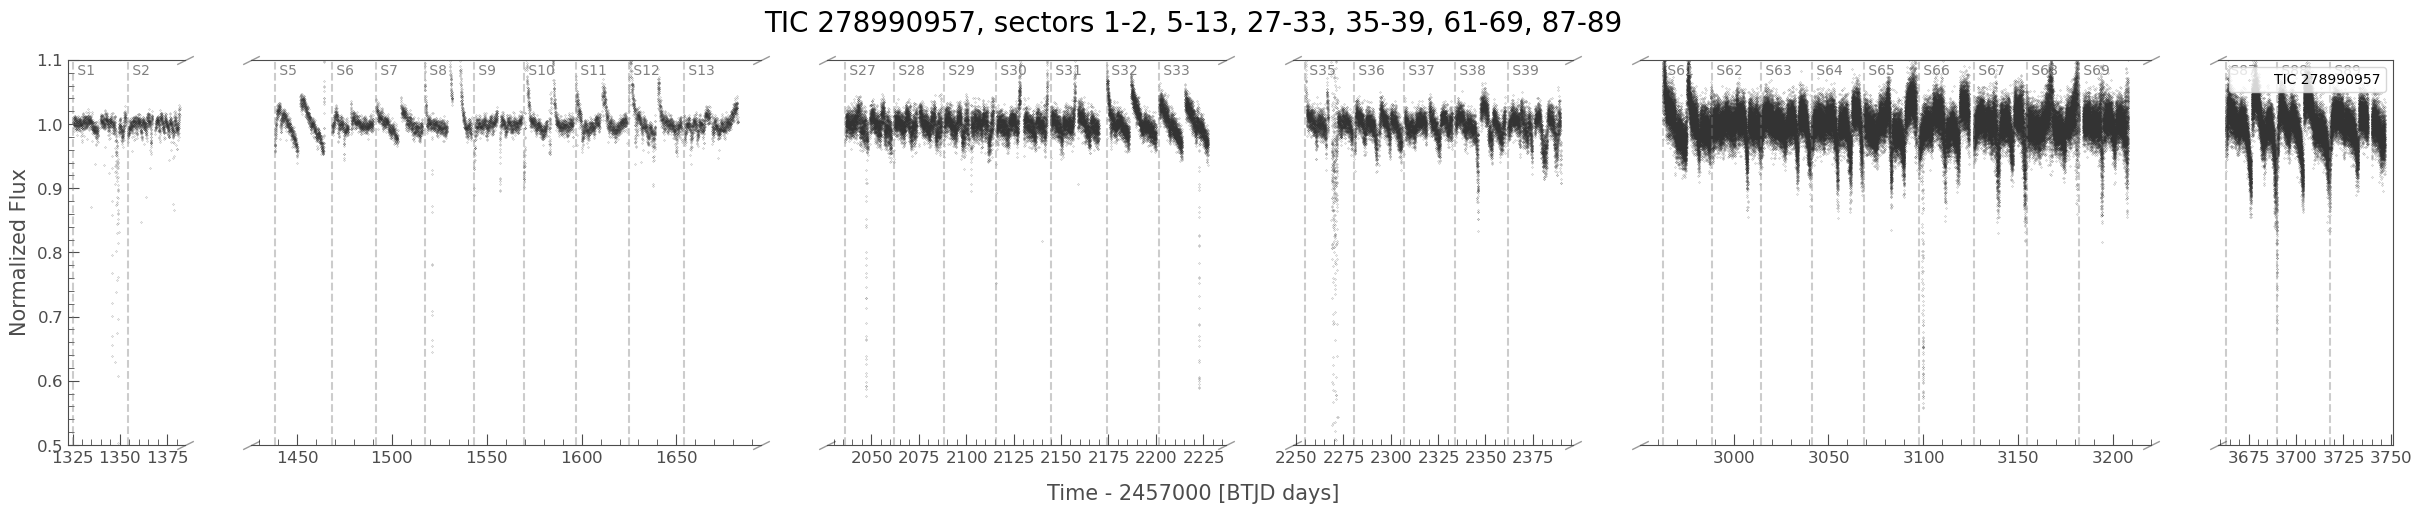

In [84]:
flux_col = "sap_flux"
# flux_col = ["kspsap_flux", "det_flux"]
# flux_col = ["kspsap_flux_sml", "det_flux_sml"]
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,
    corrector_func=lambda lc: lke.select_flux(lc, flux_col),
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=0.1, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.5, 1.1) for ax in axs];

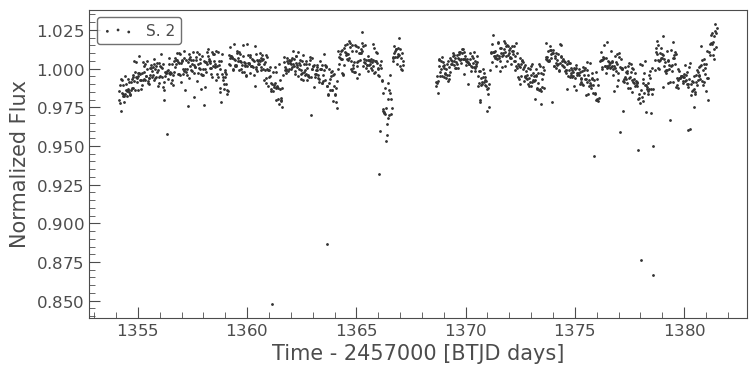

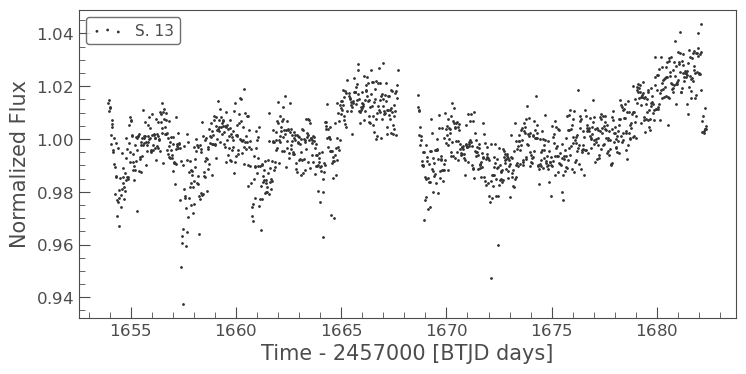

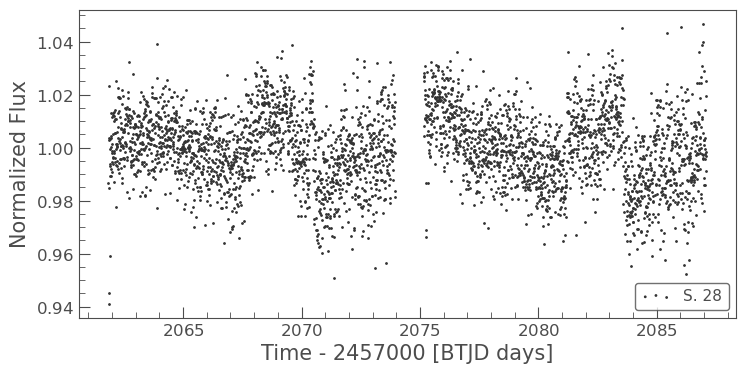

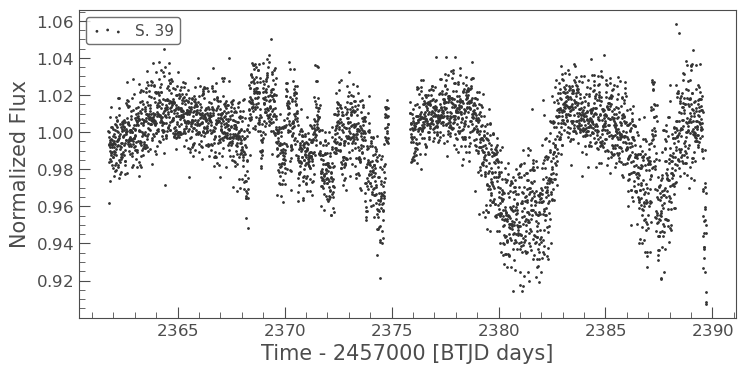

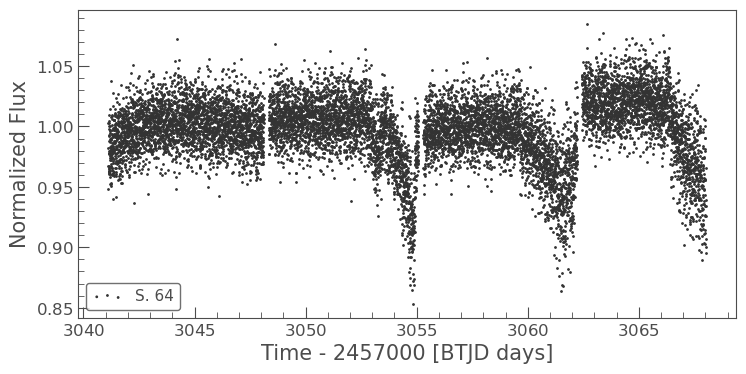

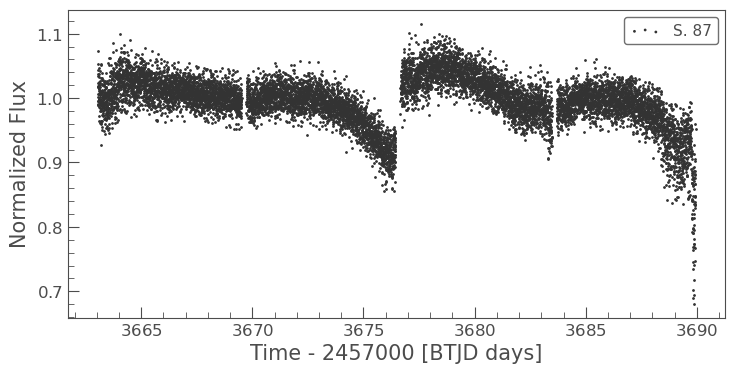

In [96]:
for sector in (2, 13, 28, 39, 64, 87):
    _lc = of_sector(lcc_tess, sector)
    ax = tplt.scatter(_lc.normalize(), label=f"S. {sector}");


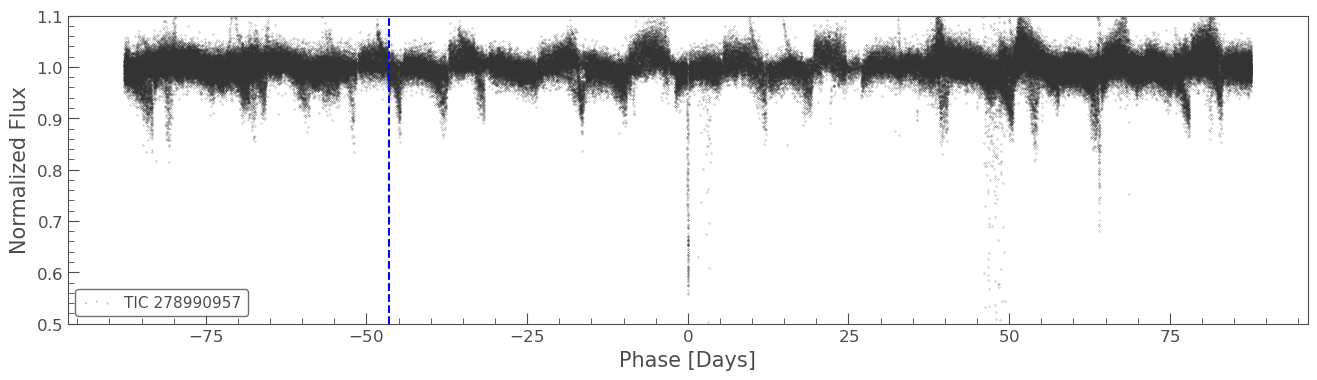

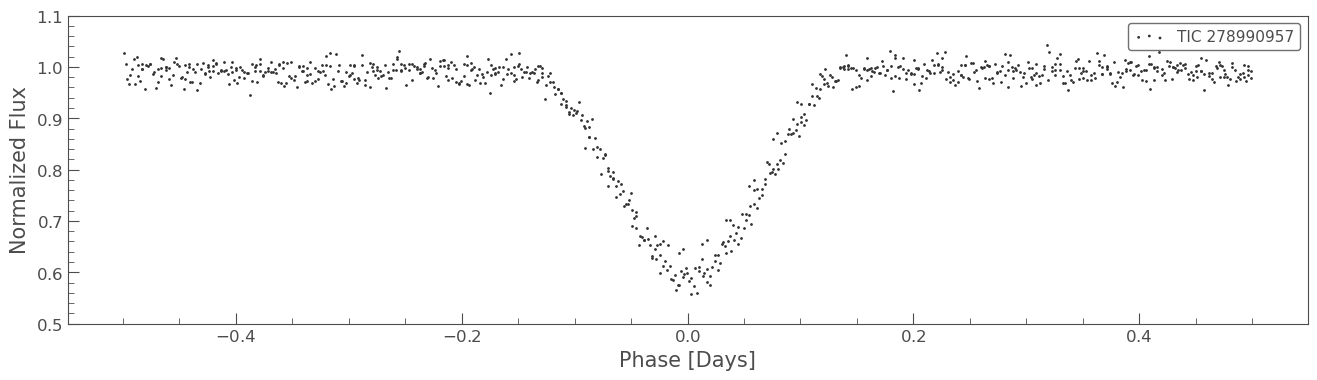

In [82]:
t0, period = tt_specs[0]["epoch"], tt_specs[0]["period"]

lc_f = lc.fold(period=period, epoch_time=t0);
ax = tplt.scatter(lc_f, s=0.1, figsize=(16, 4));
ax.axvline(0 - 46.49, c="blue", linestyle="--", label="EB-shallow");
ax.set_ylim(0.5, 1.1);


ax = tplt.scatter(lc_f.truncate(-0.5, 0.5), s=4, figsize=(16, 4));
ax.set_ylim(0.5, 1.1);


### Compare the lightcurves from different pipelines

SearchResult containing 3 data products.

 #     mission     year       author      exptime target_name distance proposal_id
                                             s                 arcsec             
--- -------------- ---- ----------------- ------- ----------- -------- -----------
  0 TESS Sector 08 2019               QLP    1800   278990957      0.0         N/A
  1 TESS Sector 08 2019 GSFC-ELEANOR-LITE    1800   278990957      0.0         N/A
  2 TESS Sector 08 2019              TGLC    1800   278990957      0.0         N/A

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\lightcurve.py:1129: LightkurveWarning: The light curve appears to be zero-centered (median=9.99e-01 +/- 2.34e+00); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


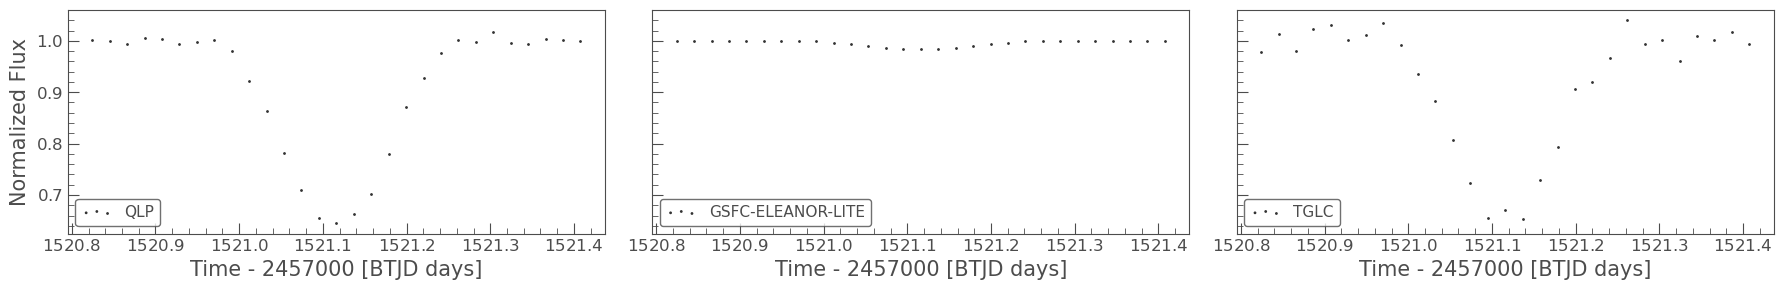

In [57]:
_sr = lk.search_lightcurve(f"TIC{tic}", sector=8)  # a deep eclipse,  use sector=6 for shallow EB
display(_sr)

lcc_p = _sr.download_all()

t0 = 1521.12
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_p), figsize=(len(lcc_p) * 6, 3), sharey=True)
    for i, _lc in enumerate(lcc_p):
        _lc = _lc.normalize().truncate(t0 - 0.3, t0 + 0.3);
        tplt.scatter(_lc, ax=axs[i], label=_lc.author);
        if i > 0: 
            axs[i].set_ylabel(None)
    plt.tight_layout();


### Check TGLC data

In [119]:
rs = await lket.search_tglc_lightcurve(tic, csv_dir=r"C:\Users\SL\Downloads\hlsp_tglc\data", grep_cmd=r"C:\pkg\ripgrep\rg -H -N")  # 261136679, #   # 
# display(rs)

lcc_tglc = lk.LightCurveCollection([ lk.read(u) for u in rs["url"] ])
lcc_tglc

# tplt.plot_all(lcc_tglc, ax_fn=lambda: tplt.lk_ax(figsize=(16, 4)));

LightCurveCollection of 24 objects:
    0: <TessLightCurve LABEL="TIC 278990957" SECTOR=1 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    1: <TessLightCurve LABEL="TIC 278990957" SECTOR=2 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    2: <TessLightCurve LABEL="TIC 278990957" SECTOR=3 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    3: <TessLightCurve LABEL="TIC 278990957" SECTOR=5 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    4: <TessLightCurve LABEL="TIC 278990957" SECTOR=6 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    5: <TessLightCurve LABEL="TIC 278990957" SECTOR=7 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    6: <TessLightCurve LABEL="TIC 278990957" SECTOR=8 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    7: <TessLightCurve LABEL="TIC 278990957" SECTOR=9 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    8: <TessLightCurve LABEL="TIC 278990957" SECTOR=10 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    9: <TessLightCurve LABEL="TIC 278990957" SECTOR=11 AUTHOR=TGLC FLUX_ORIGIN=cal_psf_flux>
    10: <TessLightCurve LABEL="TIC 2789909

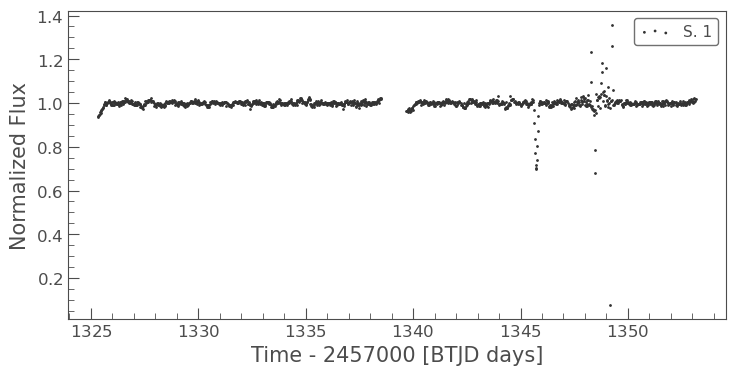

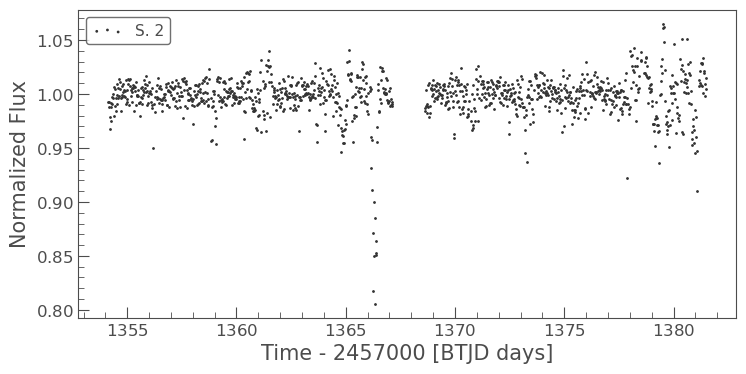

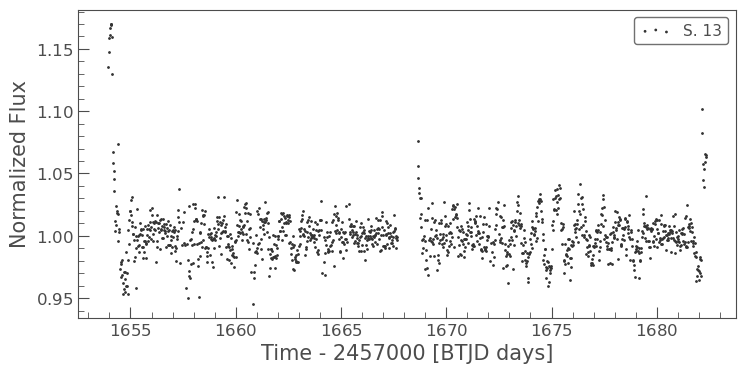

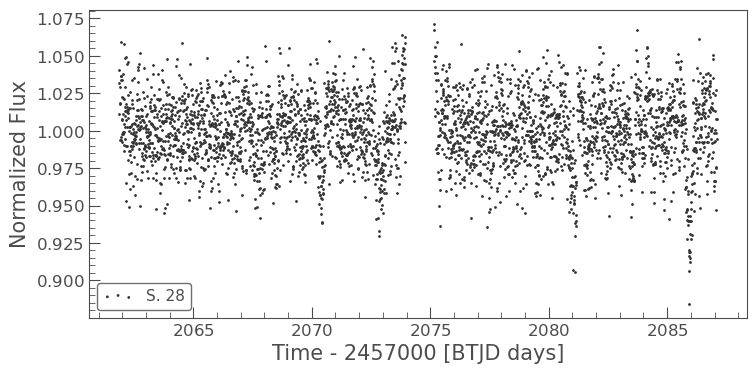

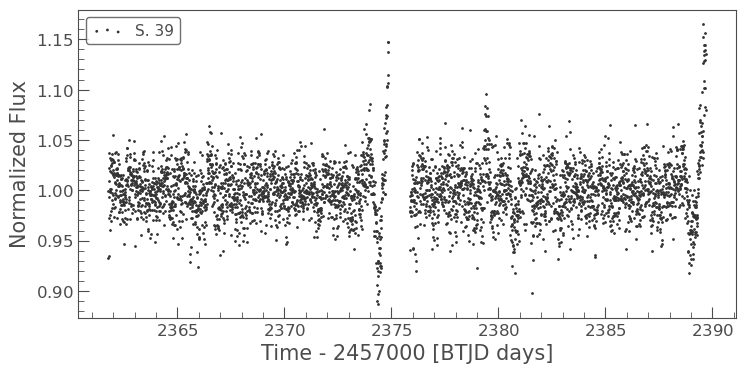

In [100]:
for sector in (1, 2, 13, 28, 39,):
    _lc = of_sector(lcc_tglc, sector)
    ax = tplt.scatter(_lc, label=f"S. {sector}");


C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\astropy\utils\masked\core.py:879: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\lightcurve.py:1129: LightkurveWarning: The light curve appears to be zero-centered (median=9.99e-01 +/- 2.34e+00); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\astropy\utils\masked\core.py:879: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)


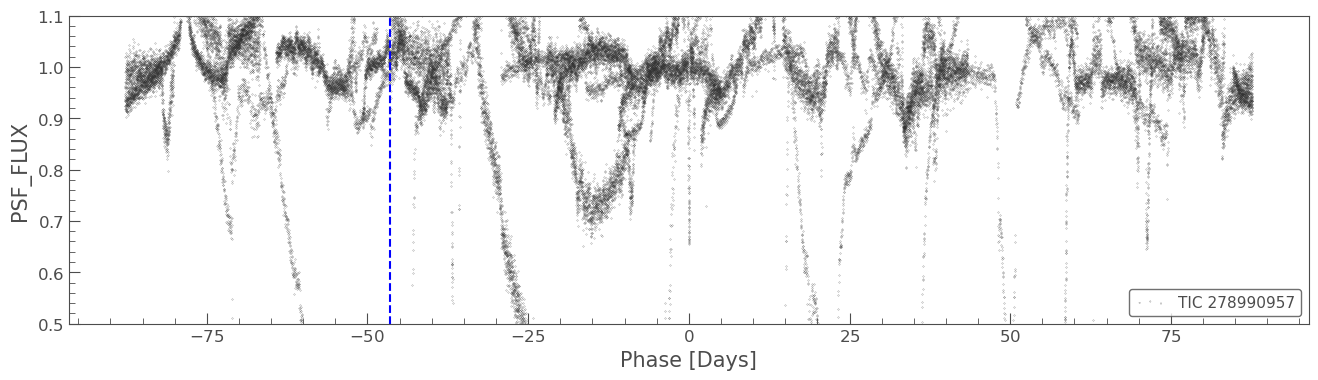

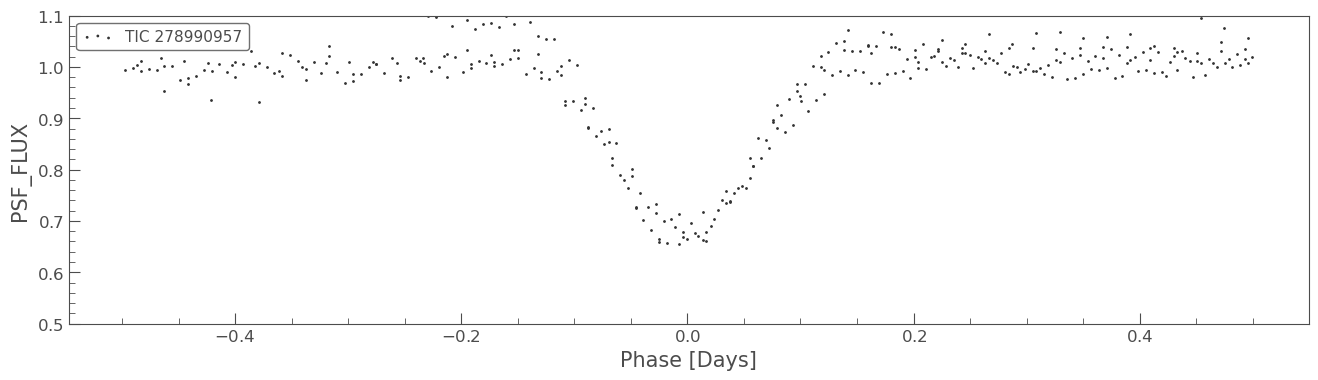

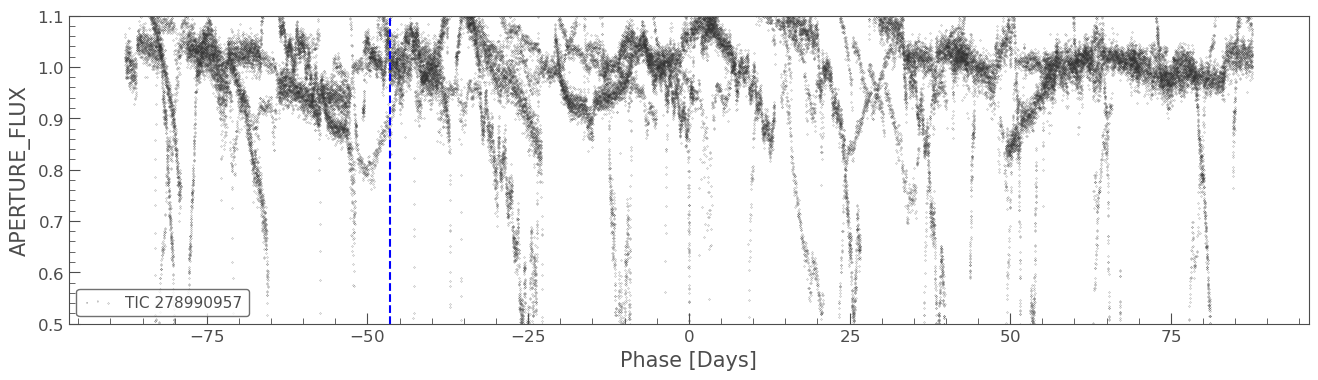

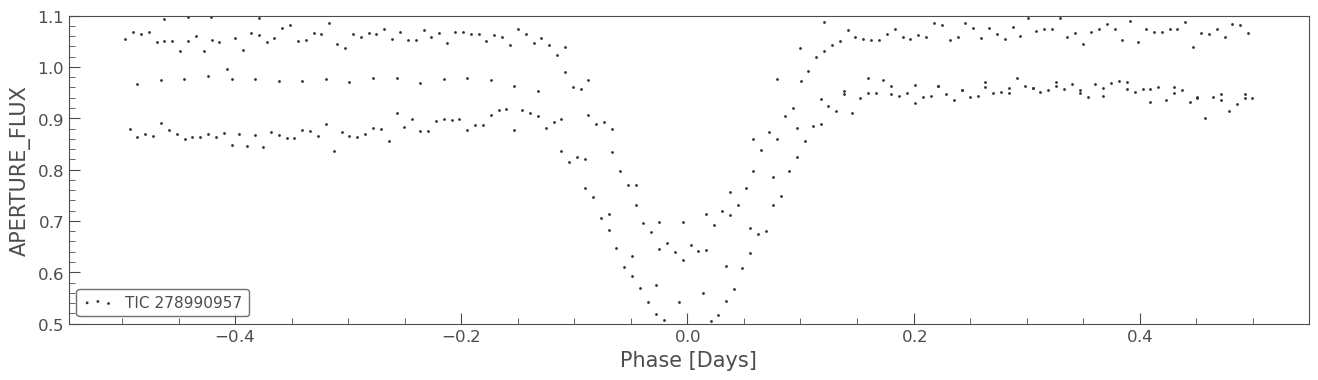

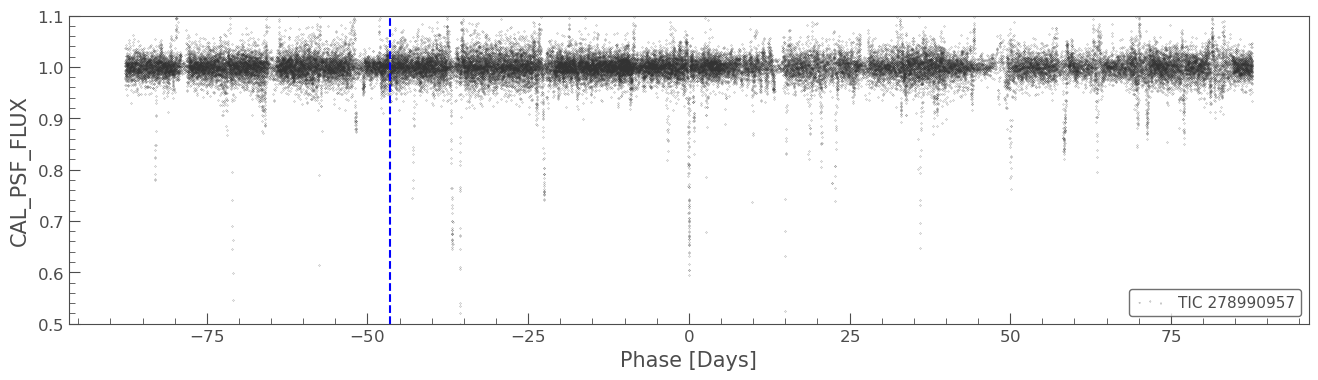

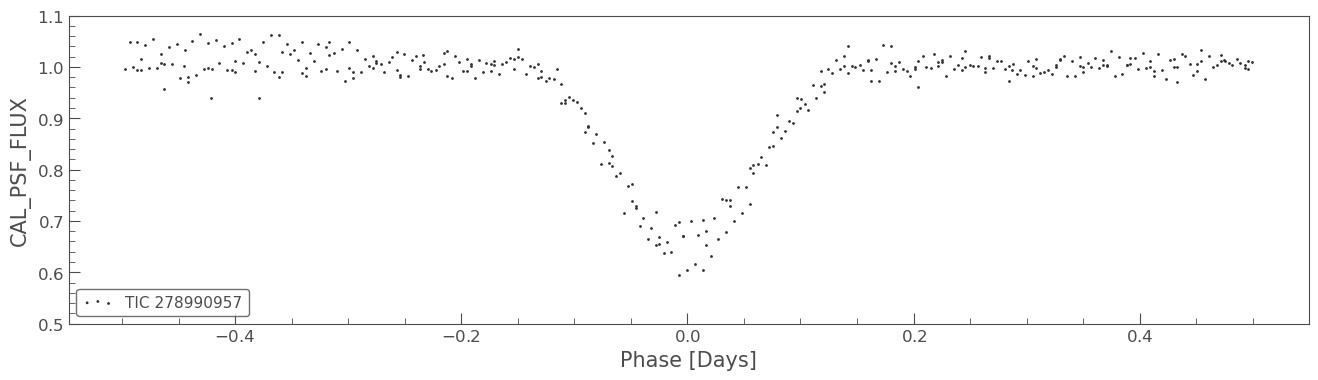

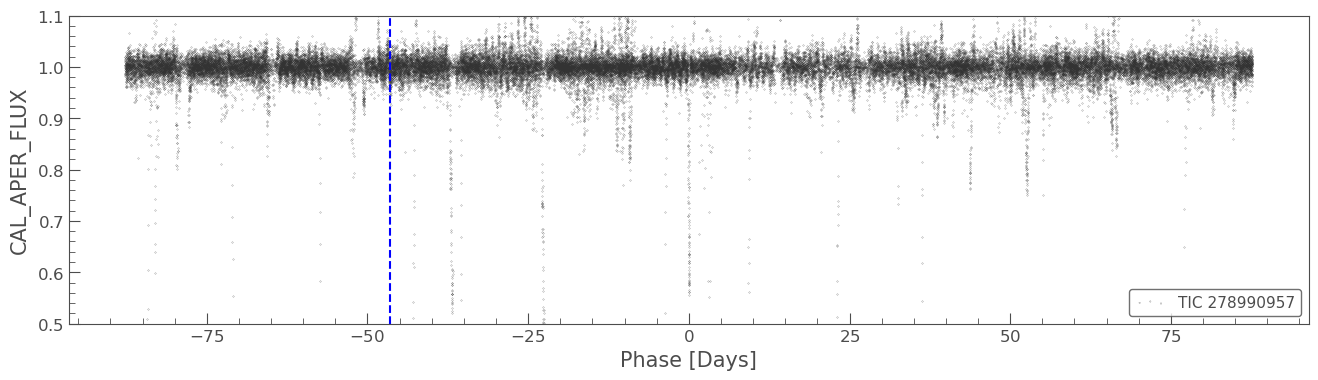

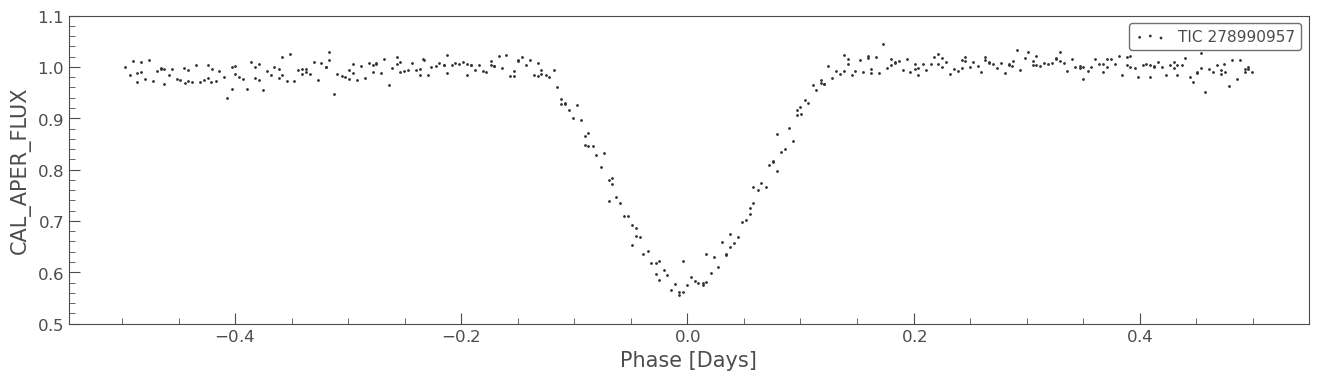

In [95]:
def _select_flux(lc, column):
    # workaround for lightkruve bug issues/1467 
    # whern flux  flux_err have different units (if chooing psf_flux or aper_flux)
    lc = lc.copy()
    lc["flux_err"] = np.full(lc["flux"].shape, np.nan) * lc[column].unit 
    lc["flux"] = lc[column]
    lc.meta["FLUX_ORIGIN"] = column.upper()
    return lc


for flux_col in ["psf_flux", "aperture_flux", "cal_psf_flux", "cal_aper_flux"]:
    lc = lke.stitch(lcc_tglc, corrector_func=lambda lc: _select_flux(lc, flux_col).normalize());
    
    t0, period = tt_specs[0]["epoch"], tt_specs[0]["period"]
    
    lc_f = lc.fold(period=period, epoch_time=t0);
    ax = tplt.scatter(lc_f, s=0.1, figsize=(16, 4));
    ax.set_ylabel(lc.flux_origin.upper());
    ax.axvline(0 - 46.49, c="blue", linestyle="--", label="EB-shallow");
    ax.set_ylim(0.5, 1.1);
    
    ax = tplt.scatter(lc_f.truncate(-0.5, 0.5), s=4, figsize=(16, 4));
    ax.set_ylabel(lc.flux_origin.upper());
    ax.set_ylim(0.5, 1.1);


---

### Compare target QLP LC with deblended contaminant SPOC LC

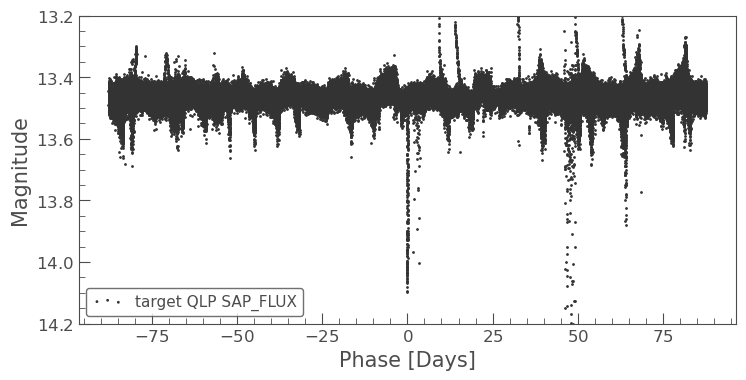

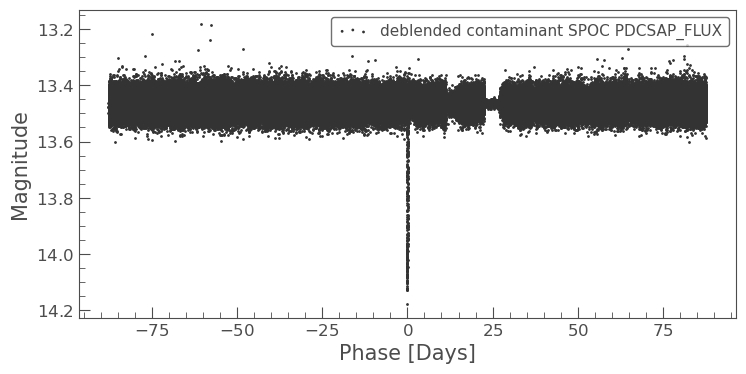

In [120]:
t0, period = tt_specs[0]["epoch"], tt_specs[0]["period"]

lc = lke.to_flux_in_mag_by_normalization(lke.stitch(lcc_tess))
ax = tplt.scatter(lc.fold(period=period, epoch_time=t0), label="target QLP SAP_FLUX")
ax.set_ylim(14.2, 13.2);

contaminant_mag = lke.combine_magnitudes(10.1864, 12.7961)
blend_mag  = lke.combine_magnitudes(13.4642, contaminant_mag)
lc_c = lke.to_flux_in_mag_by_normalization(lke.stitch(lcc_tess_c), base_mag=blend_mag)
# ax = tplt.scatter(lc_c.fold(period=period, epoch_time=t0), label="contaminant SPOC PDCSAP_FLUX");

lc_c_db = lke.deblend_mag(lc_c, contaminant_mag)
ax = tplt.scatter(lc_c_db.fold(period=period, epoch_time=t0), label="deblended contaminant SPOC PDCSAP_FLUX");


### Conclusion

- The target's QLP LC is comparable to deblended contaminant SPOC LC (in range)
- Use deblended contaminant SPOC LC as it has higher cadence, and the out-of-eclipse data is probably more reliable (less fluctation that might be due to scattered light or processing)

## Gaia DR3 info (coordinate, etc.)

In [105]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=20, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


The target is also listed as an astrometric binary with 177.74 d (+/- 1.33 d) period in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-source=I%2F357&Source=5483610730803645312)


In [124]:
primary_name = f"TIC {tic}"  # Keep the existing name even though the ID is wrong. It's close enough and from a Vairable catalog
primary_name

'TIC 278990957'

In [ ]:
import lightkurve_ext_readers as lker
# reload(lker)
reload(tplt)

# https://asas-sn.osu.edu/sky-patrol/coordinate/7fe2c085-8849-46fc-9aa6-20da0efd20e4
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic61768908_asas_sn_light_curve_7fe2c085-8849-46fc-9aa6-20da0efd20e4.csv")  
lc = lc.select_flux("mag")
lc = lc.remove_nans()
lc = lc.remove_nans(column="flux_err")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.errorbar_partition_by(lc, partition_by_column="filter", ax=ax);
# ax.set_title(ax.get_title());

lc_asassn = lc  # keep the reference in a meaninfgul name for use in subsequent cells
print("Before filtering:", len(lc_asassn), np.nanmedian(lc_asassn.fwhm))  # some basic stats


lc_asassn_original = lc_asassn
lc_asassn = lc_asassn[lc_asassn.mag_err.value < 0.1]  # remove data points with large errors
ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.errorbar_partition_by(lc_asassn, partition_by_column="filter", ax=ax);
ax.set_title(ax.get_title() + "\nData with large error filtered")

print("After filtering:", len(lc_asassn), np.nanmedian(lc_asassn.fwhm))  # some basic stats

## Combining all data, crowding corrected

TESS # data points: 376762


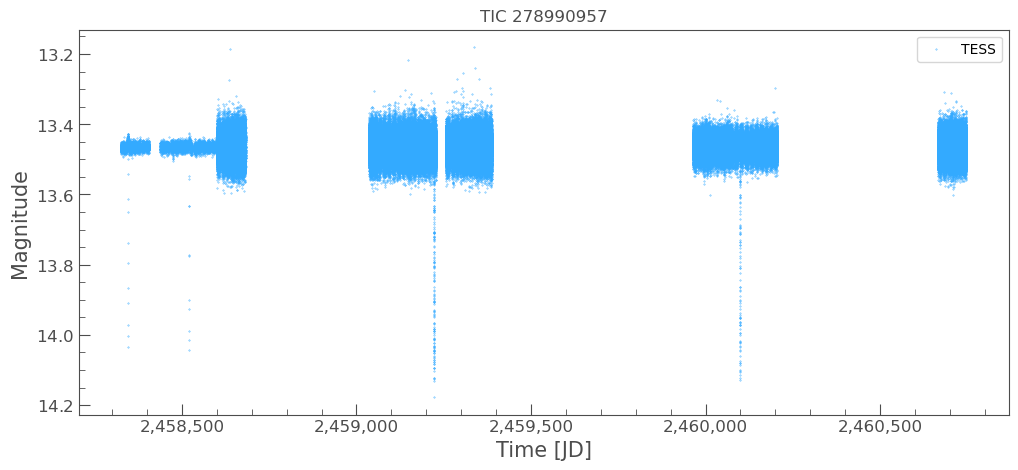

In [125]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess_blended = lke.stitch(lcc_tess_c, ignore_incompatible_column_warning=True, )
lc_tess_blended = lc_tess_blended.remove_nans().remove_nans(column="flux_err")


# see https://exofop.ipac.caltech.edu/tess/nearbytarget.php?id=278990957
contaminant_mag = lke.combine_magnitudes(
    10.1864,  # TIC 278990954
    12.7961  # TIC 278990956
)
blend_mag  = lke.combine_magnitudes(
    13.4642, # (target) TIC 278990957
    contaminant_mag
)
lc_tess_blended = lke.to_flux_in_mag_by_normalization(lc_tess_blended, base_mag=blend_mag)
lc_tess = lke.deblend_mag(lc_tess_blended, contaminant_mag)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
    }, 
    shift_to=None,
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Initial Rough epoch / period / duration

In [132]:
#
# Tentative Eclipse parameters, from inspection
#

# tt_specs = TransitTimeSpecList(  #
#     dict(epoch=1521.12, duration_hr=6.5, period=175.394, label="EB-deep",
#          sector=8, steps_to_show=[0],
#     ),
#     dict(epoch=1650.02, duration_hr=9, period=175.394, label="EB-shallow",
#          sector=12, steps_to_show=[0],
#     ),

# reload(lket)

    
period_initial = 175.394

epoch_time_btjd_initial = 1521.12
epoch_time_hjd_initial = round(lket.btjd_to_hjd_utc(epoch_time_btjd_initial, target_coord), 2)
epoch_time_min_ii_btjd_initial = 1650.02
epoch_time_min_ii_hjd_initial = round(lket.btjd_to_hjd_utc(epoch_time_min_ii_btjd_initial, target_coord), 2)

duration_hr_min_i_initial = 6.5
duration_hr_min_ii_initial = 9.0


#### Determine contaminant V mag
Use transformd V mag from Gaia DR3 Gmag, with zero point adjustment using combined  Vmag max in ASAS-SN V as the reference.

In [ ]:
# combined Vmag max:
# - the  existing VSX range of 14.49 - 14.72 V does not fit ASAS-SN V data well here
combined_v_mag_max  = 14.57  # visual inspection based on median around maxima

lc = lc_combined_dict["ASAS-SN V"].copy()
lc.label = "ASAS-SN V"
# lc = lc_combined_dict["TESS"]
ax = tplt.errorbar(lc, c="green", figsize=(16, 6));
ylim = (None, None)
# ylim = (14.9, 14.35)
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

# a rough phase plot
lc_f = lc.fold(period=period_initial, epoch_time=epoch_time_hjd_initial)
ax = tplt.errorbar(lc_f, c="green", figsize=(16, 6));
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

hw = 0.1

# get the median around maxima
lc_trunc = lk.LightCurveCollection([
    lc_f.truncate(-period_initial / 4 - hw, -period_initial / 4 + hw),
    lc_f.truncate(period_initial / 4 - hw, period_initial / 4 + hw),
]).stitch(corrector_func=lambda lc: lc)

len(lc_trunc), np.nanmedian(lc_trunc.flux)

In [ ]:
target_gmag_max = 15.56  # from visual inspection Gaia DR3 photometry
target_g_vmag_max = lke.gaia_dr3_mag_to_vmag(target_gmag_max, 0.654)  
print("target V max from Gaia G:", target_g_vmag_max)

contaminant_g_vmag = lke.gaia_dr3_mag_to_vmag(14.651, 1.317)  # from Gaia DR3 Gmag and B-R 
print("contaminant V from Gaia G:", contaminant_g_vmag)  

combined_g_vmag_max= lke.combine_magnitudes(target_g_vmag_max, contaminant_g_vmag)
print("Combined V max from Gaia G:", combined_g_vmag_max)

zero_point_offset = combined_v_mag_max - combined_g_vmag_max
print("Zero point offset:", zero_point_offset)

contaminant_vmag = contaminant_g_vmag + zero_point_offset
contaminant_vmag = round(contaminant_vmag, 2)
print("Contaminant Vmag, zero point adjusted, rounded:", contaminant_vmag)

Target Max in Gaia DR3 G band

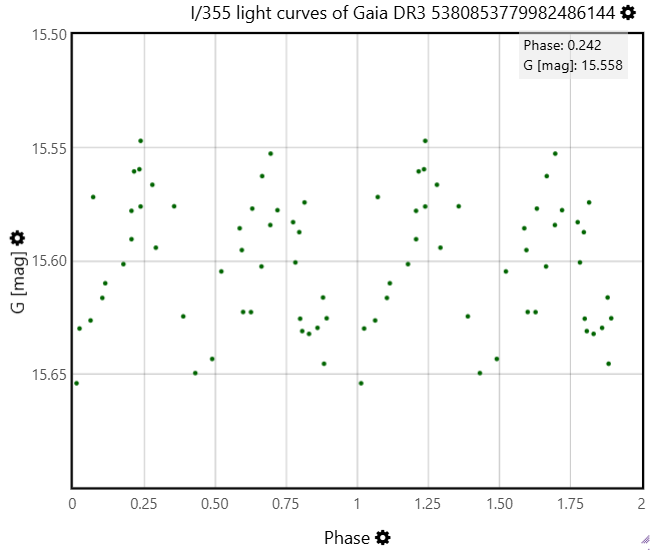

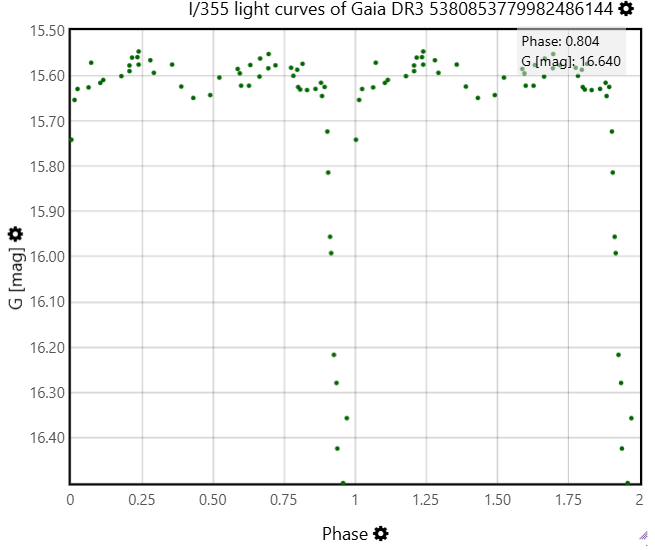


#### Beblend ASAS-SN data and TESS data

In [ ]:
lc_asassn_v_c = lke.deblend_mag(lc_combined_dict["ASAS-SN V"], contaminant_vmag)
# Note: for ASAS-SN g, we deblend the ASAS-SN g **zero-shfited to V**, 
lc_asassn_g_c = lke.deblend_mag(lc_combined_dict["ASAS-SN g"], contaminant_vmag) 

lc_tess_c = lke.deblend_mag(lc_tess[lc_tess.flux.value < 13.9838], 13.9838)  # faint outliers in TESS data would cause deblend fail (error in log), remove thouse outliers
lc_combined_dict_c = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess_c, 
     "ASAS-SN V": lc_asassn_v_c,
     "ASAS-SN g": lc_asassn_g_c,
    }, 
    shift_to="ASAS-SN V"  
)



#### plot combined results with initial period / epoch (with crowding correction)

In [ ]:
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
plot_options[0][1]["s"] = 9  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[1][1]["markersize"] = 9  # make markers for Hp larger

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd_initial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (18.5, 15.0)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd_initial, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_ylim(*ylim);
ax.set_xlim(-0.2, 0.2);  # to see primary in details

# Copy the deblending result to VSX deblend spreadsheet to ensure the implementaion is correct
# lc_combined_dict["ASAS-SN V"].remove_nans().to_pandas().to_clipboard()
# lc_asassn_v_c.to_pandas()["flux"].to_clipboard()


## Refine epoch / period / duration

In [ ]:
lcc = []
# here we use the *combined flux*  (rather than deblneded one)
# because the deblend procedure loses error (the error will still be useful in MCMC)
for key, lc in lc_combined_dict.items():
    if key == "TESS":
        # the amplitude of TESS is noticably smaller than others, 
        # skip them to make the period fits (in MCMC) easier
        continue
    lc = lc.copy()
    lc["band"] = key
    lc = lke.to_normalized_flux_from_mag(lc)
    lc = lc["time", "flux", "flux_err"]   # avoid incompatibility in other unused columns in stitch() below
    lcc.append(lc)
lcc = lk.LightCurveCollection(lcc)
lc = lcc.stitch();

# axs = tplt.plot_skip_data_gap(lc);

# remove obvious outliers
# lc = lc.truncate(0.5, 1.2, column="flux").remove_nans();


### Use MCMC to model primary eclipses

- I need to use **blended LC** because MCMC need flux_err, deblended lc has no error

len(lc_f_min_i): 305


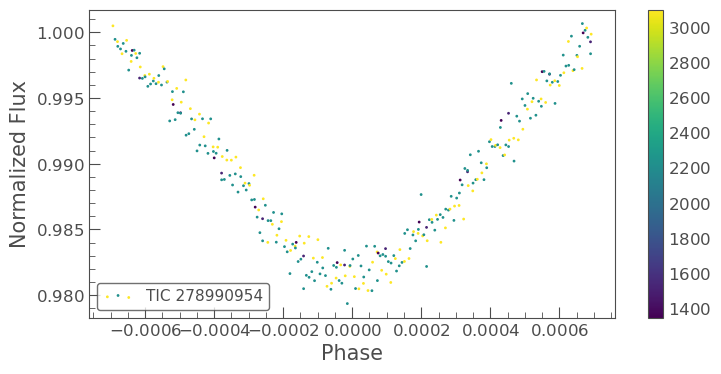

In [144]:
# I need to use blended LC because MCMC need flux_err, deblended lc has no error
lc = lke.to_normalized_flux_from_mag(lc_tess_blended)  # in BTJD!!!

# Prepare the clipped LC for MCMC
lc_f_min_i = lc.fold(epoch_time=epoch_time_btjd_initial, period=period_initial, normalize_phase=True)
lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_initial / 24 * 0.45) / period_initial, (0 + duration_hr_min_i_initial /24 * 0.45) / period_initial)
ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value);

# lc_f_min_i = lc.remove_outliers(sigma_lower=6, sigma_upper=5).fold(epoch_time=epoch_time_hjd_trial, period=period_trial, normalize_phase=True)
# lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_trial / 24 * 0.40) / period_trial, (0 + duration_hr_min_i_trial /24 * 0.40) / period_trial)
# ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value, label="outliers removed");

print("len(lc_f_min_i):", len(lc_f_min_i))


In [146]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = lc_f_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.019, 0, 0.00035, 0.9]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)
# etv_functions.plot_initial_guess(lc_f_data, None, None, None, "0", *start_vals)

if np.all(np.isnan(lc_f_data.err)):  # a sanity check to avoid errors down when doing fitting
    raise ValueError("err must be non-nan for ETV (e.g., deblended data often has no err)")

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.27it/s]


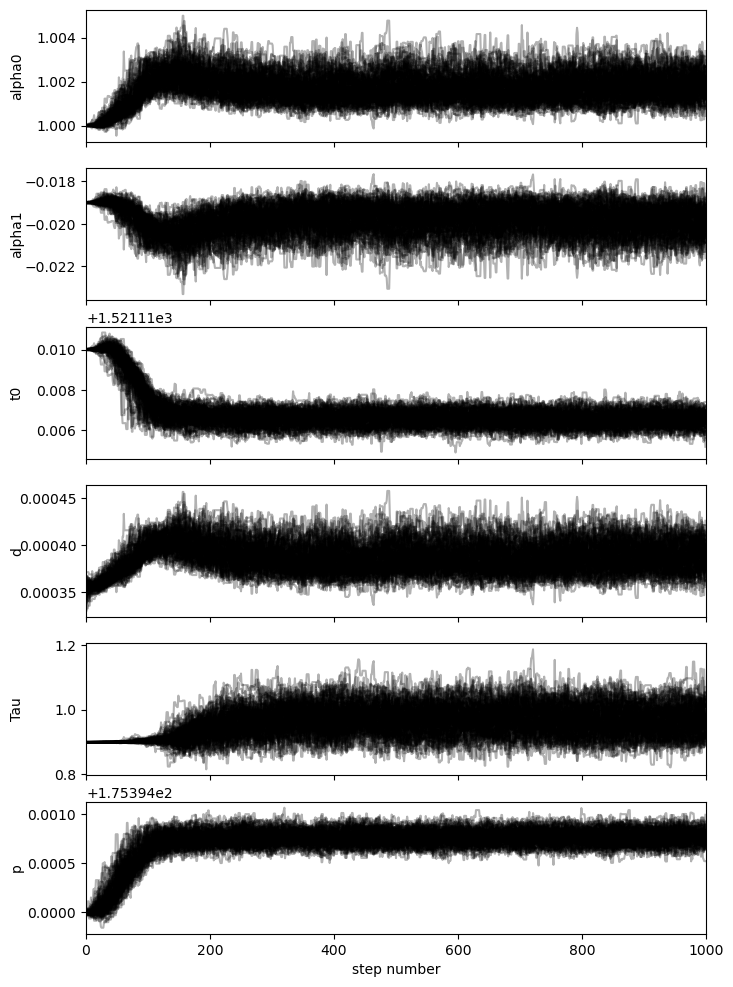

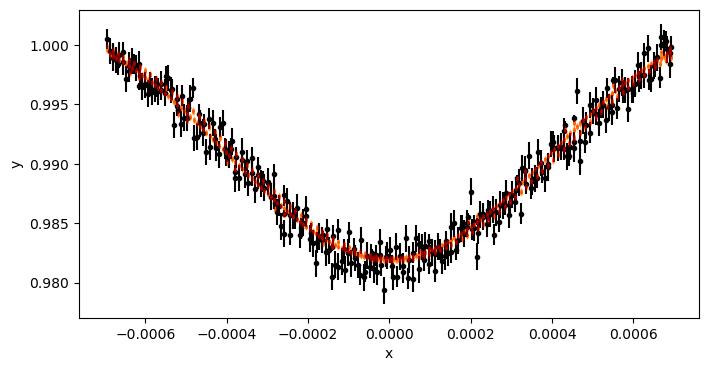

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0017227863167784, -0.019771900796741473, 1521.1165593342423, 0.00038592213764655764, 0.9689796247628039, 175.3947691394418
std_p: 7.089955995319252e-05
std_t0 0.0003659452906519355


In [155]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.019, epoch_time_btjd_initial, 0.00035, 0.9, period_initial],
    # nruns=5000, discard=4000,
    nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_p:", fit_params_p_stats["std_p"])
print("std_t0", fit_params_p_stats["std_t0"])

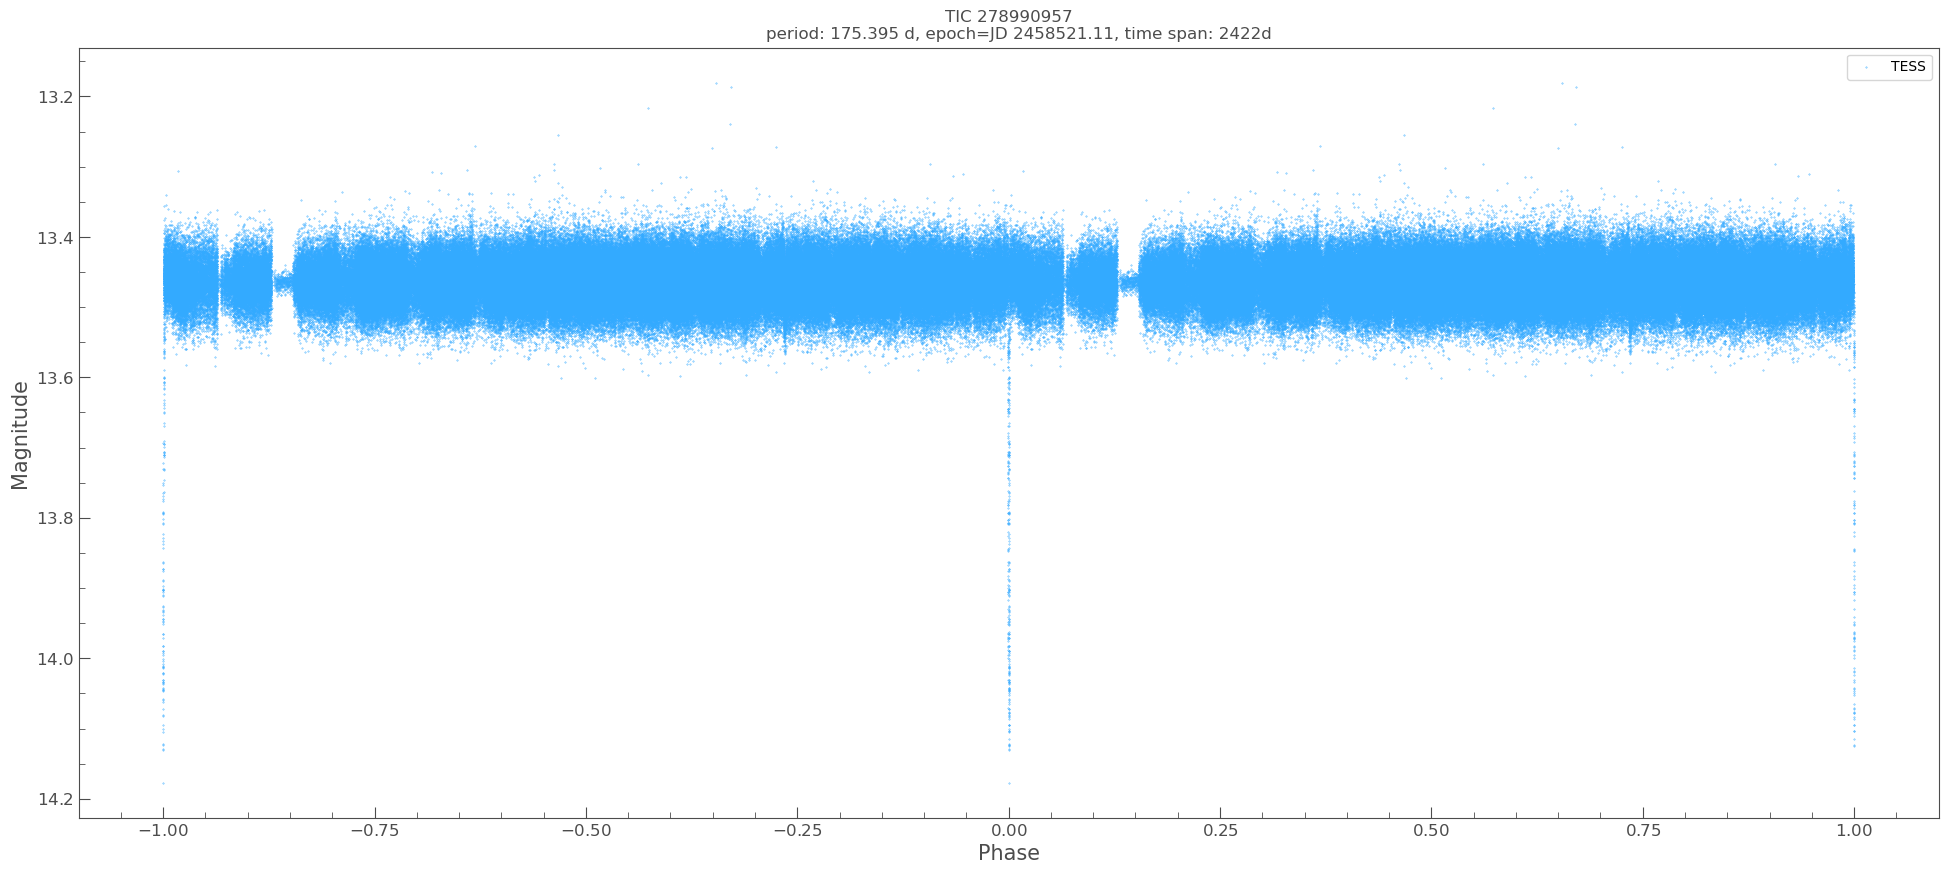

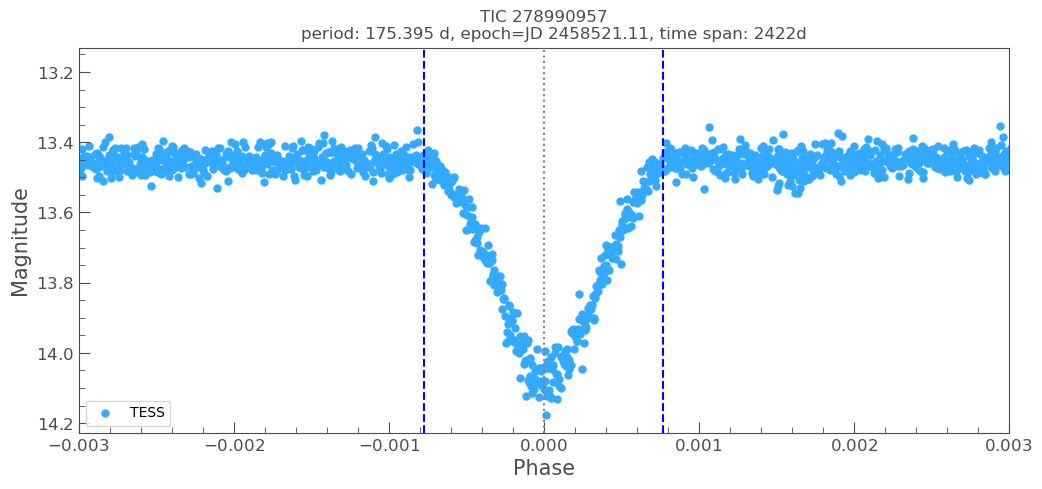

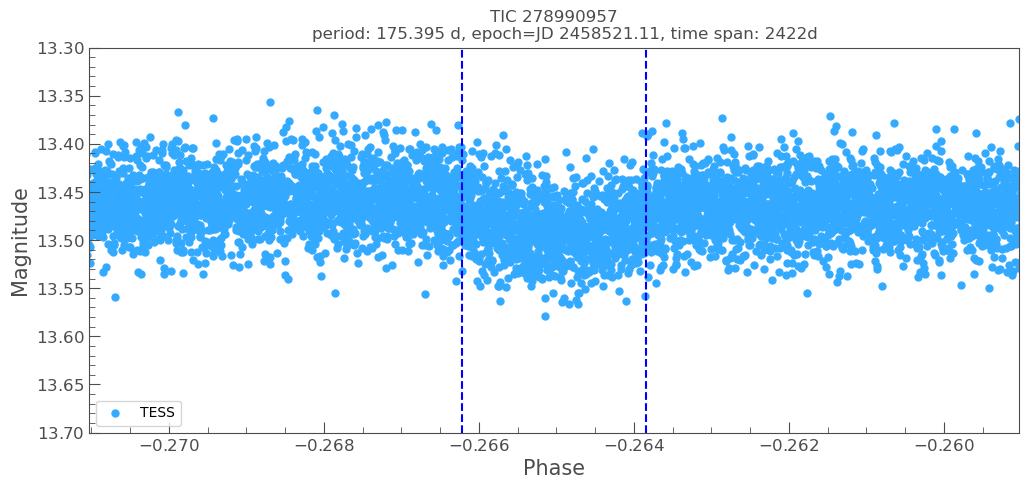

In [187]:
period_trial2 = round(175.3947691394418, 3)  # MCMC, err = 7e-5
# epoch_time_btjd_trial2 = round(1521.1165593342423, 2)  # MCMC, err= 0.0003659452906519355
epoch_time_btjd_trial2 = 1521.11  # tweaked from visual inspection
epoch_time_hjd_trial2 = round(lket.btjd_to_hjd_utc(epoch_time_btjd_trial2, target_coord), 2)
epoch_time_min_ii_hjd_trial2  = epoch_time_min_ii_hjd_initial 
duration_hr_min_i_trial2 = duration_hr_min_i_initial
duration_hr_min_ii_trial2 = 10.0

epoch_phase_min_ii_trial2 = abs(epoch_time_min_ii_hjd_trial2 - epoch_time_hjd_trial2) / period_trial2 % 1
if epoch_phase_min_ii_trial2 > 0.5:
    epoch_phase_min_ii_trial2 = epoch_phase_min_ii_trial2 - 1
epoch_phase_min_ii_trial2 = round(epoch_phase_min_ii_trial2, 5)  # to reach a precision of about .01 day


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    # plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial2,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
# ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.003, 0.003);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_trial2,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_trial2,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(13.7, 13.3);
ax.legend(loc="lower left");
ax.axvline(0.5, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_trial2-0.006, epoch_phase_min_ii_trial2+0.006);  # to see Min II in details


### Final epoch / period / duration

In [189]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_trial2
epoch_time_hjd_final = epoch_time_hjd_trial2
epoch_phase_min_ii_final = epoch_phase_min_ii_trial2
duration_hr_min_i_final = duration_hr_min_i_trial2 
duration_hr_min_ii_final = duration_hr_min_ii_trial2 

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)

# Min II : at phase 0.5


Adopted period / epoch / duration_hr:  175.395 2458521.11 6.5 10.0


## Determine Magnitude Range (crowding corrected TESS)


Min mag # num data points: 11
['13.46', '14.08']


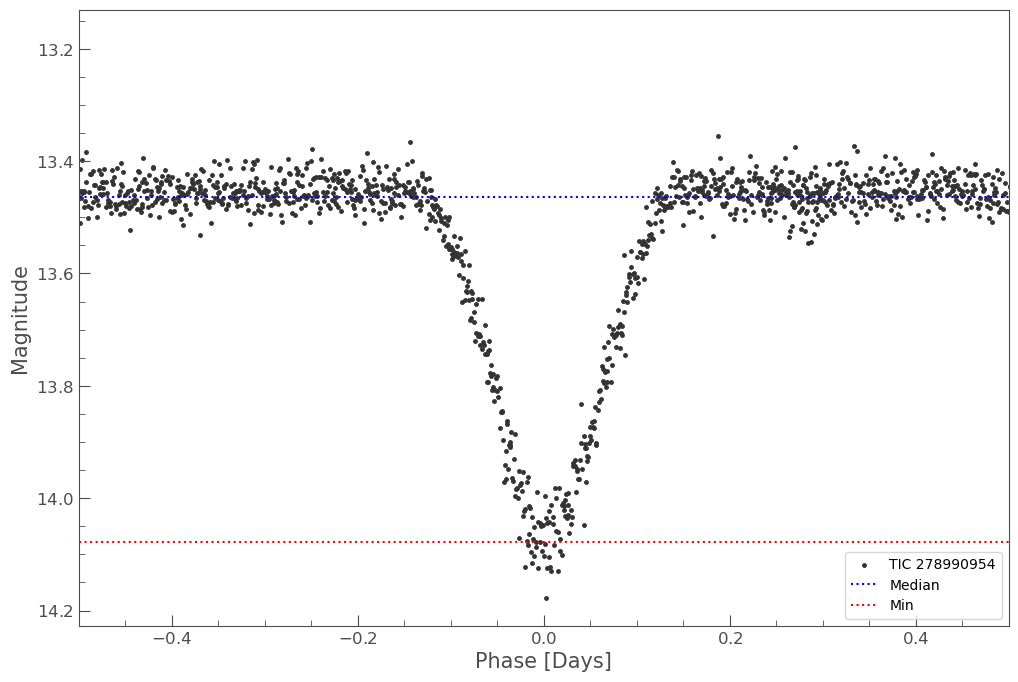

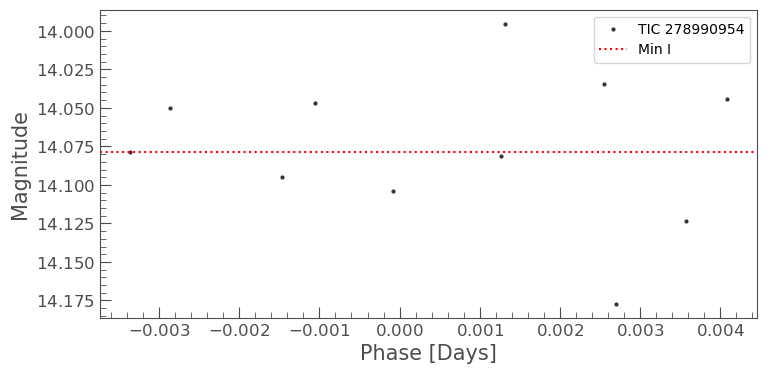

In [196]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 6/24/60, 0 + 6/24/60)
print("Min mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 1)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, s=25, ax=ax);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
# ax.axhline(max_flux_mag, c="red", linestyle="dashed", label="Max")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min")
ax.legend(loc="lower right");
ax.set_xlim(-0.5, 0.5); 
# ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

ax = tplt.scatter(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag]])


## Plots for VSX

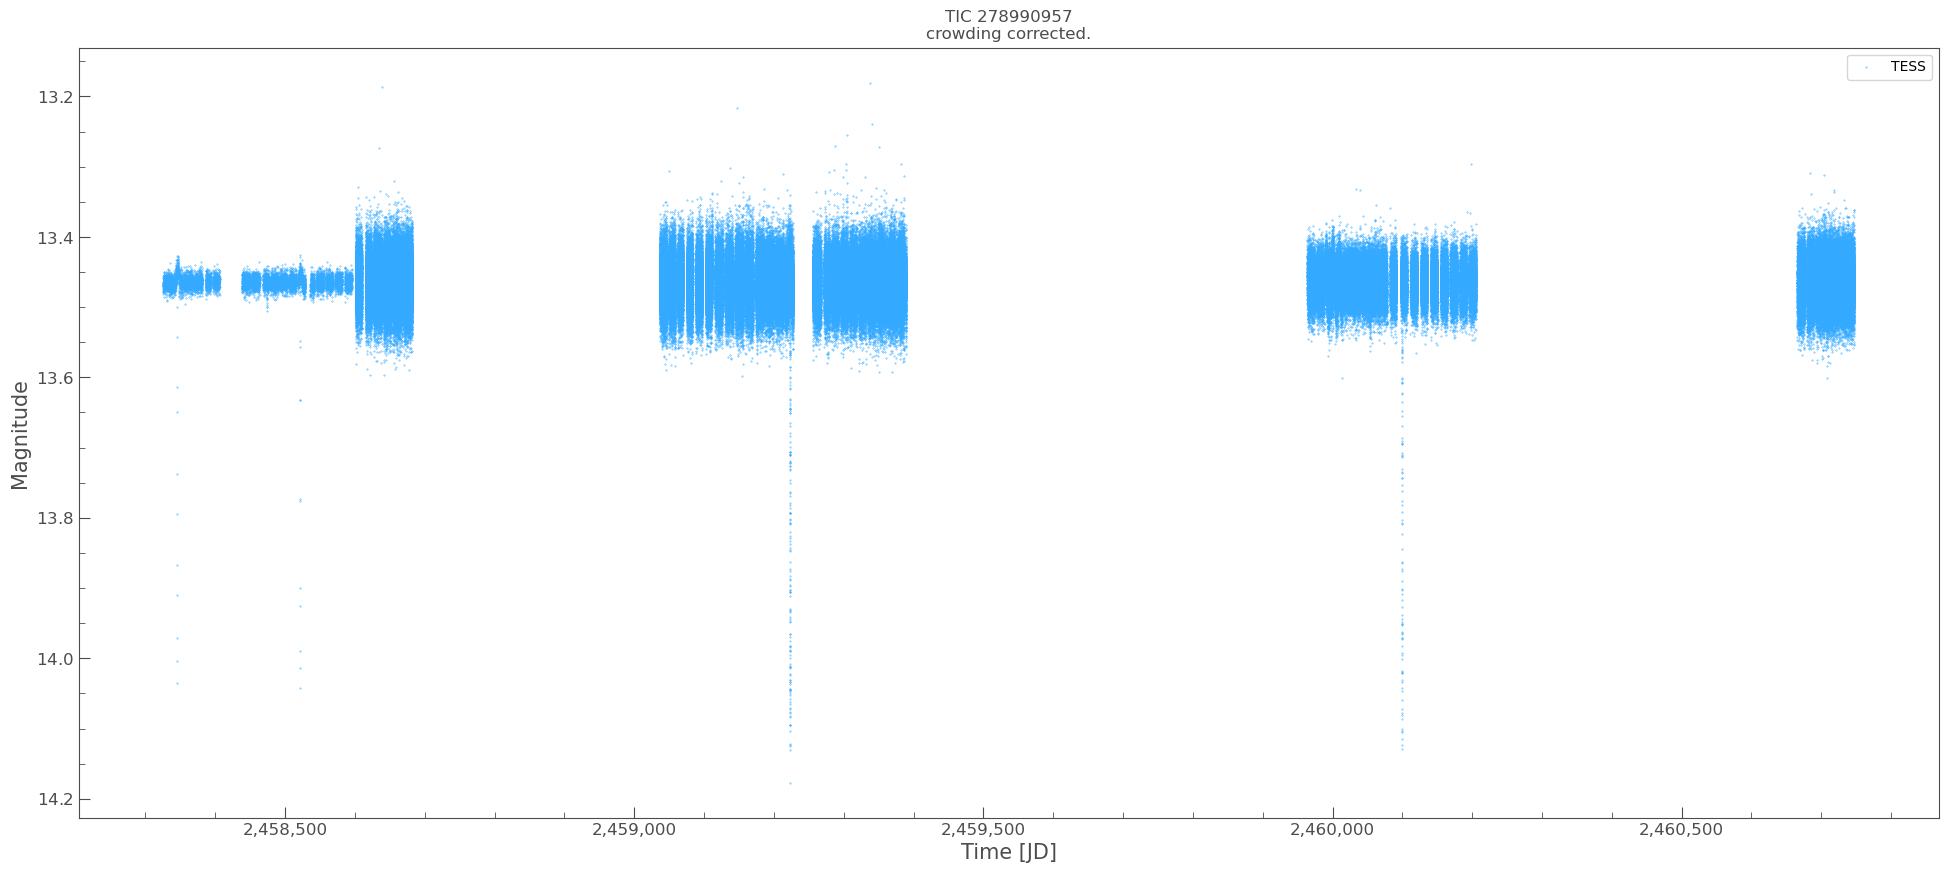

In [198]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "\ncrowding corrected.");

#### Phase Plot, with crowding correction 



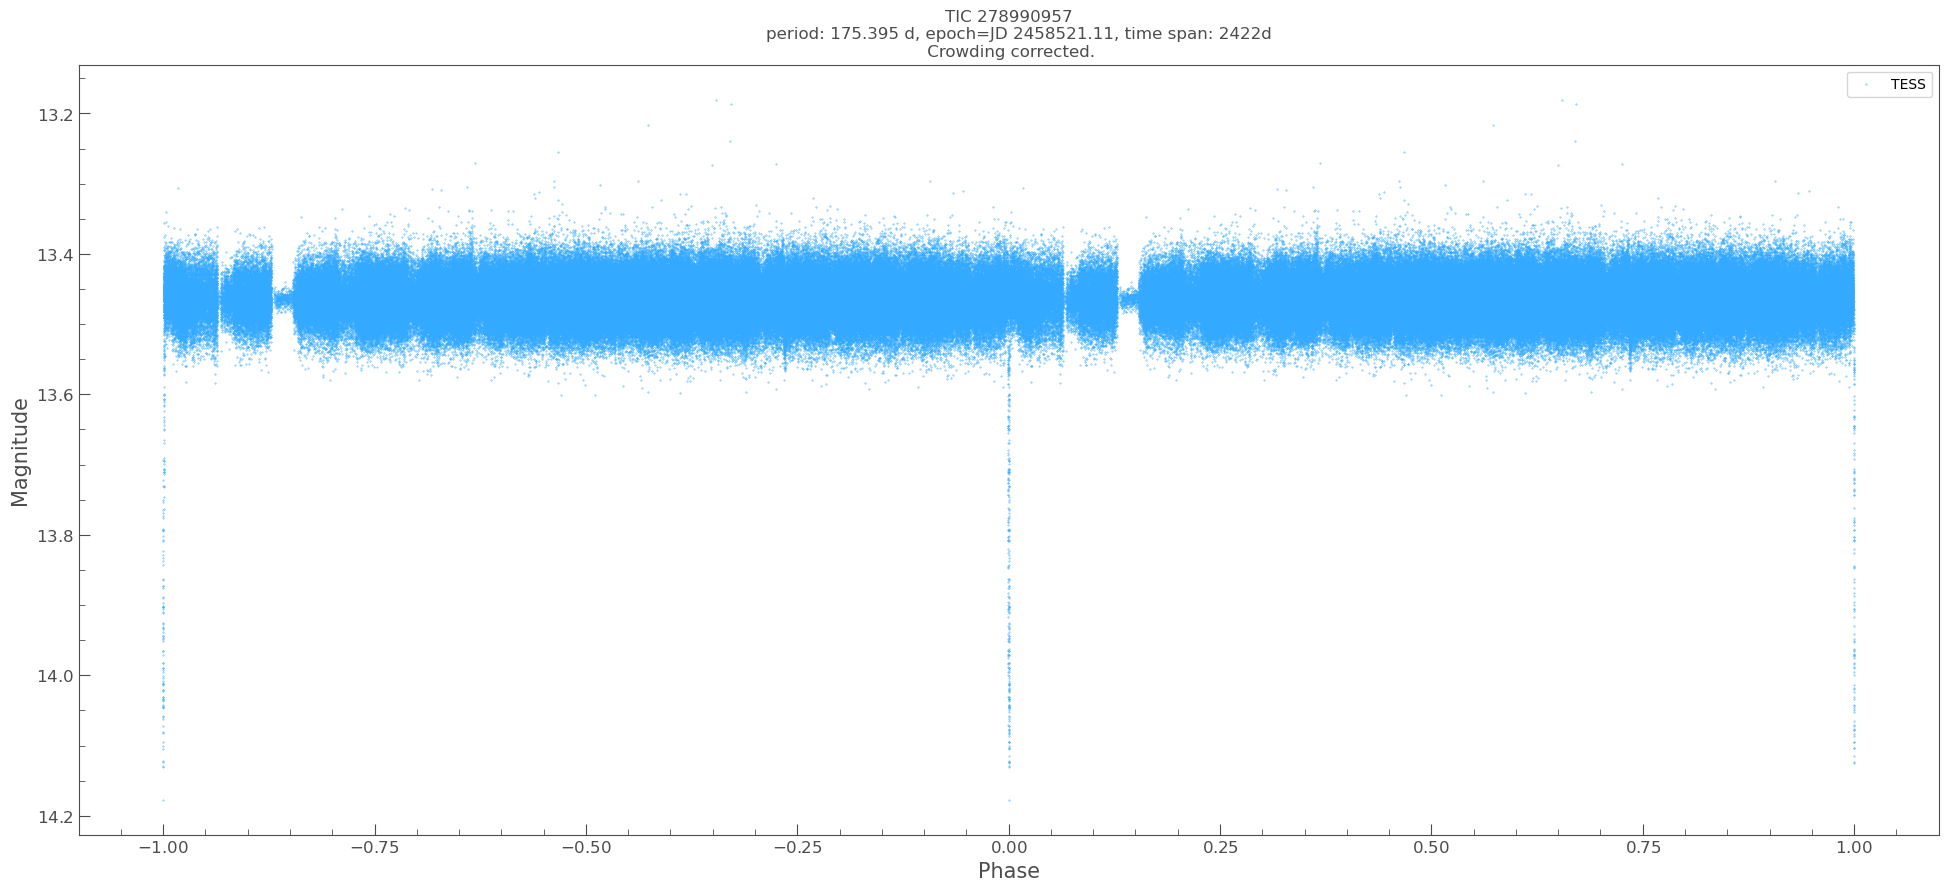

In [199]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[0][1]["s"] = 4
# plot_options[1][1]["markersize"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, None)
# ylim = (18.6, 15.0)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Crowding corrected.");


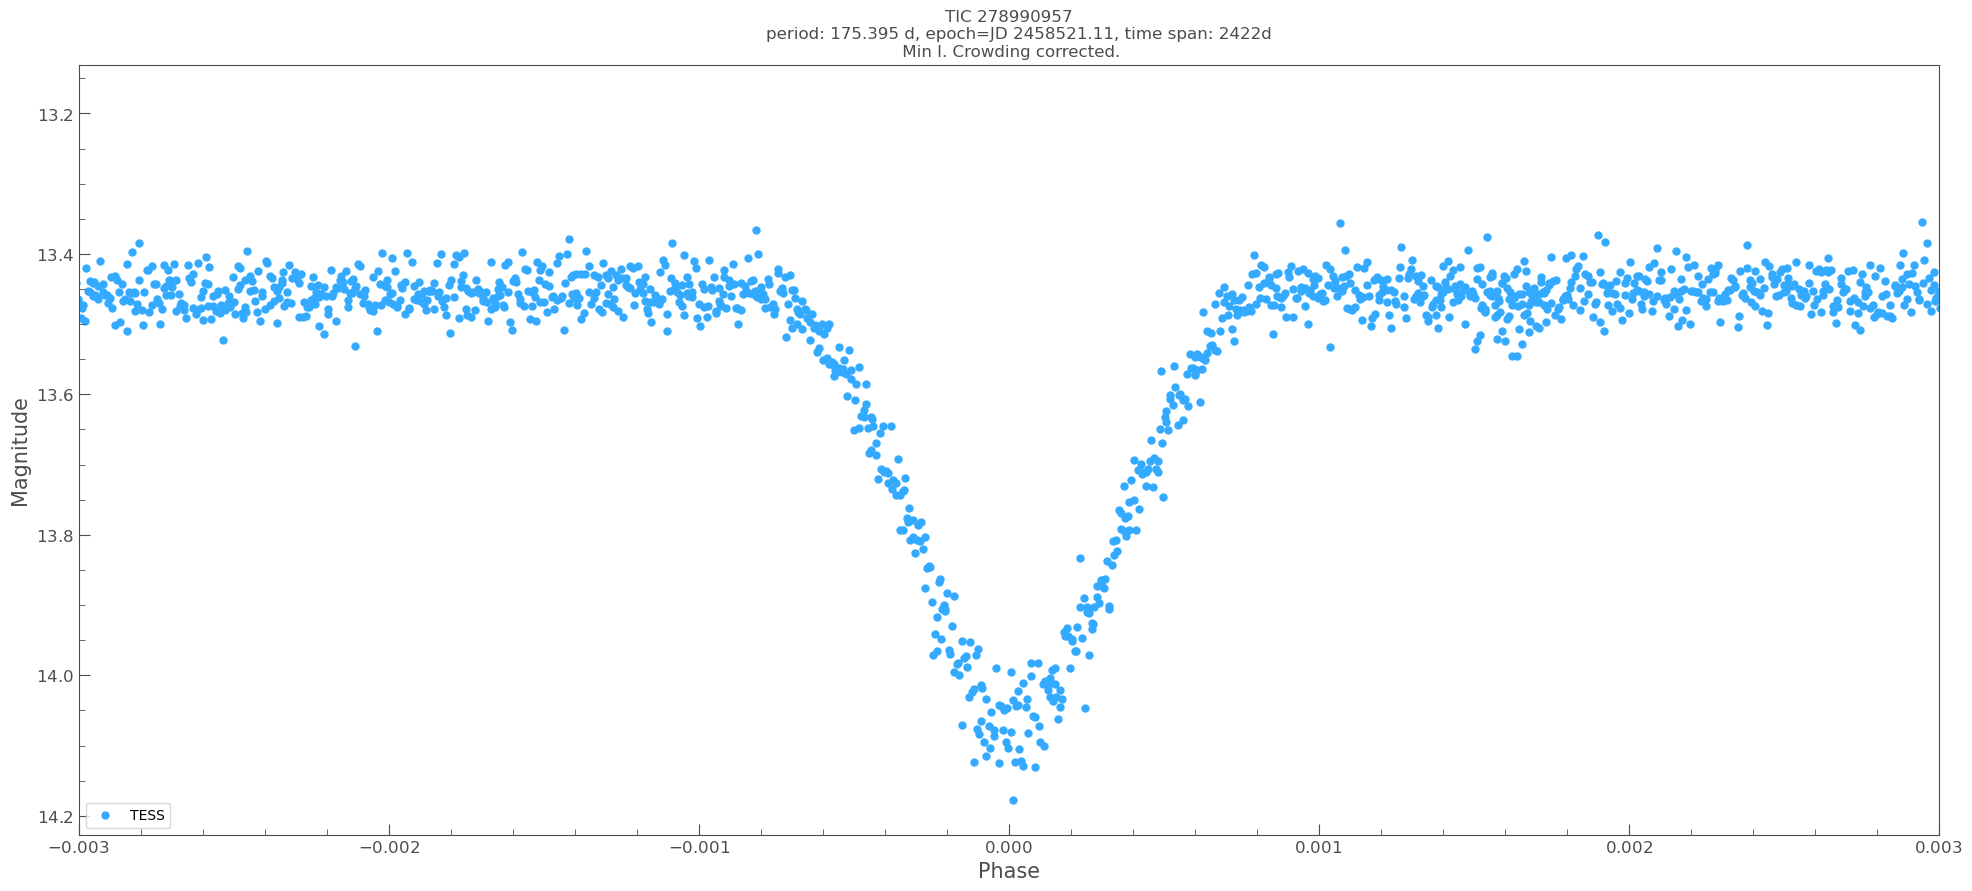

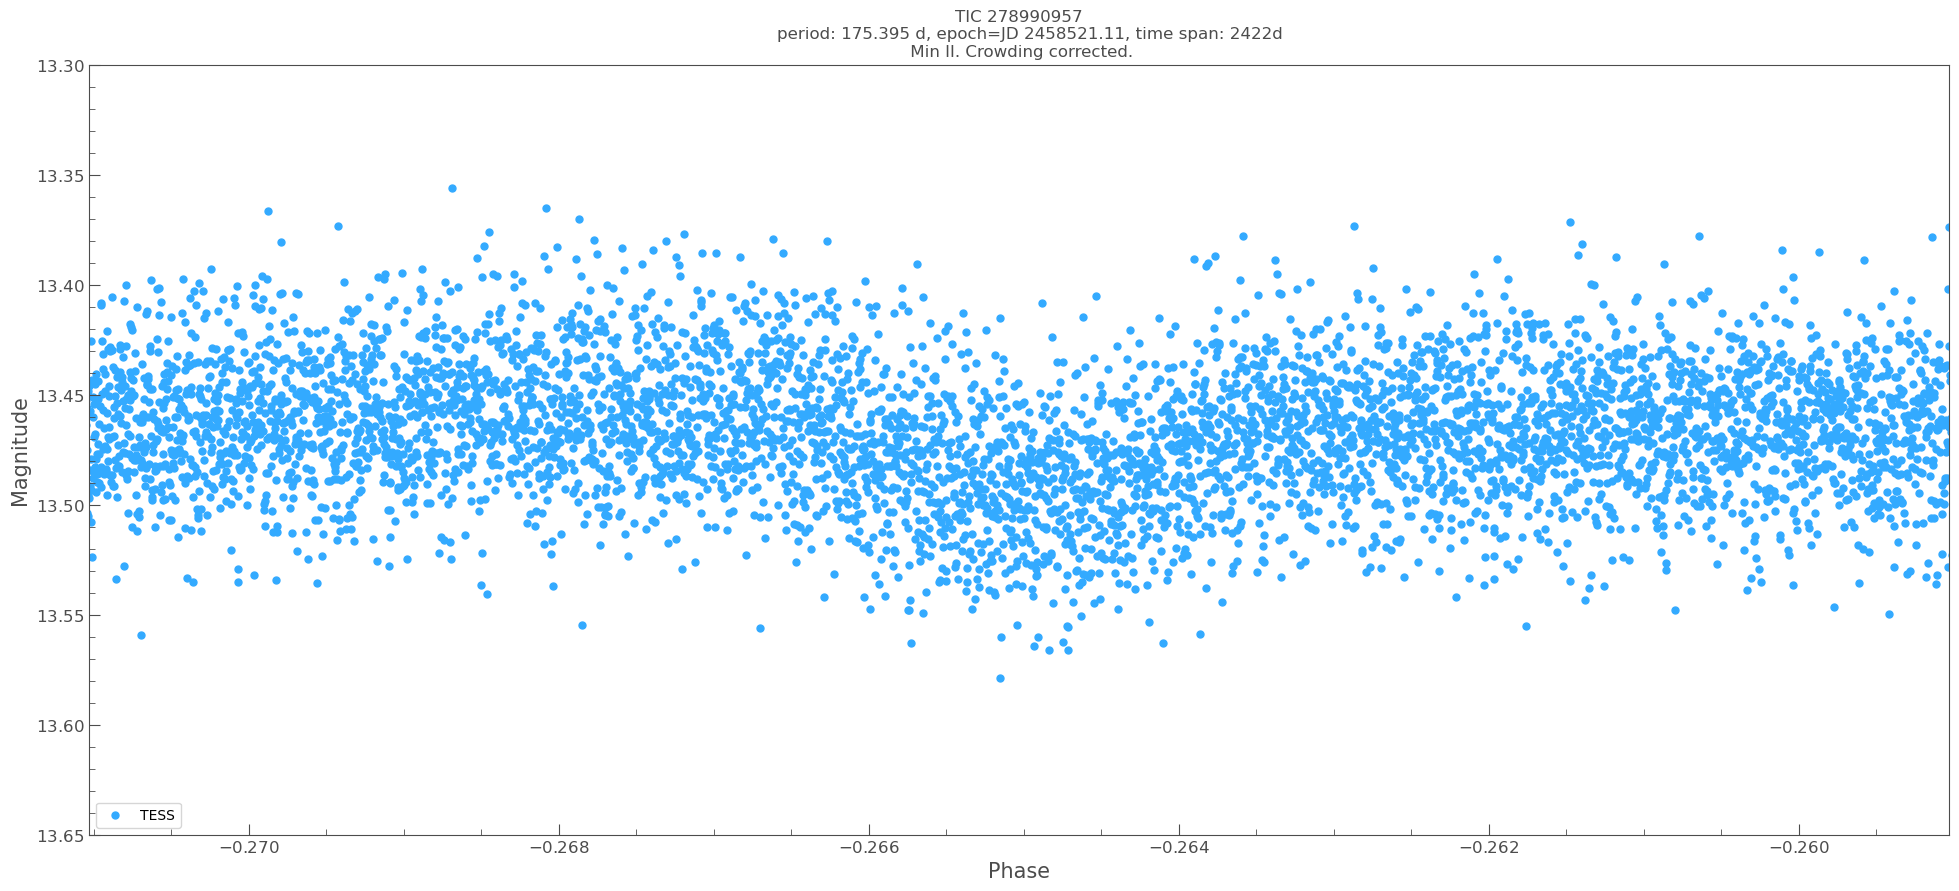

In [225]:
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
# ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.003, 0.003);  # to see primary in details
ax.set_title(ax.get_title() + "\n Min I. Crowding corrected.");


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final,
    plot_options=plot_options_zoom,
    figsize=(24, 10),
    # mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(13.65, 13.3);
ax.legend(loc="lower left");
ax.axvline(0.5, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_final-0.006, epoch_phase_min_ii_final+0.006);  # to see Min II in details
ax.set_title(ax.get_title() + "\n Min II. Crowding corrected.");


## VSX Report Table

In [204]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [234]:
import bibs_utils
# reload(bibs_utils)

other_names = f"UCAC4 160-008726"  # ExoFOP  and  https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ68067f0a1d05ca&-out.add=.&-source=I/322A/out&UCAC4===160-008726
other_names += ",2MASS J06480117-5808018"  # ExoFOP  and https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ680680351f06ac&-out.add=.&-source=II/246/out&2MASS===06480117-5808018
other_names += ",GSC 08548-01705"  # https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ68067f991ddc48&-out.add=.&-source=I/255/out&GSC=0854801705


remarks = (
    f"""Min II phase: {epoch_phase_min_ii_final}. """
    f"""TESS data contaminated by TIC 278990954 (TESS=10.19; 16" to the SE) and TIC 278990956 (TESS=12.80; 10" to the E). Range has been corrected. 2021MNRAS.501.4669E misidentified TIC 278990954 as the source (of type EP:)."""  
)

revision_comment = "Identification from centroid analysis on TESS data. Type, period, epoch, eclipse duration and range from TESS data. Position and spectral type from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="K",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{median_flux_mag:.2f}",  # treated median as max as it's mostly constant outside of eclipses
    Maximum_Magnitude_band="TESS",
    Minimum_Magnitude=f"{min_flux_mag:.2f}", 
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=False,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.2f}",  # use 2 decimal points as it's < 1%
    Discoverer="Eisner, N. L.; et al.",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.TESS_SPOC_N,
    Reference1_Bib=BIBS.TESS_SPOC_B,
    Reference2_Name="Eisner, N. L.; et al., 2021, Planet Hunters TESS II: findings from the first two years of TESS",
    Reference2_Bib="2021MNRAS.501.4669E"
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic61768908_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic278990957_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from nearby TIC 278990954 TESS data, crowding corrected.
tic278990957_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I.
tic278990957_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom)- EA Phase Plot, zoomed to Min II.
""")


Other Names (1 line each):
UCAC4 160-008726
2MASS J06480117-5808018
GSC 08548-01705

Min II phase: -0.26503. TESS data contaminated by TIC 278990954 (TESS=10.19; 16" to the SE) and TIC 278990956 (TESS=12.80; 10" to the E). Range has been corrected. 2021MNRAS.501.4669E misidentified TIC 278990954 as the source (of type EP:).

Identification from centroid analysis on TESS data. Type, period, epoch, eclipse duration and range from TESS data. Position and spectral type from Gaia DR3.


Field  \
0                  Position   
1              Primary_Name   
2               Other_Names   
3             Variable_Type   
4             Spectral_Type   
5   Spectral_Type_Uncertain   
6         Maximum_Magnitude   
7    Maximum_Magnitude_band   
8         Minimum_Magnitude   
9    Minimum_Magnitude_band   
10     Minimum_Is_Amplitude   
11                   Period   
12                    Epoch   
13        Rise_Duration_Pct   
14               Discoverer   
15                  Remarks   
16         Revision_Comment   
17          Reference0_Name   
18           Reference0_Bib   
19          Reference1_Name   
20           Reference1_Bib   
21          Reference2_Name   
22           Reference2_Bib   

                                                                                                                                                                                                                                               Value  
0                                                                                                                                                                                                                   102.00495918457, -58.13384412086  
1                                                                                                                                                                                                                                      TIC 278990957  
2                                                                                                                                                                                           UCAC4 160-008726,2MASS J06480117-5808018,GSC 08548-01705  
3                                                                                                                                                                                                                                                 EA  
4                                                                                                                                                                                                                                                  K  
5                                                                                                                                                                                                                                              False  
6                                                                                                                                                                                                                                              13.46  
7                                                                                                                                                                                                                                               TESS  
8                                                                                                                                                                                                                                              14.08  
9                                                                                                                                                                                                                                               TESS  
10                                                                                                                                                                                                                                             False  
11                                                                                                                                                                                                                                           175.395  
12                                                                


tic278990957_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from nearby TIC 278990954 TESS data, corrected.
tic278990957_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I.
tic278990957_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom)- EA Phase Plot, zoomed to Min II.



In [217]:
# Use striaght V from Gaia DR3 G mag, of 15.00, without the zero point correction to ASAS-SN V 
lc_asassn_v_c1 = lke.deblend_mag(lc_combined_dict["ASAS-SN V"], 15.00)  # contaminant_vmag
# Note: for ASAS-SN g, we deblend the ASAS-SN g **zero-shfited to V**, 
lc_asassn_g_c1 = lke.deblend_mag(lc_combined_dict["ASAS-SN g"], 15.00)   # contaminant_vmag

# TESS remains unchanged ,as I just use striaght Tmag from TIC
lc_tess_c1 = lke.deblend_mag(lc_tess[lc_tess.flux.value < 13.9838], 13.9838)  # faint outliers in TESS data would cause deblend fail (error in log), remove thouse outliers
lc_combined_dict_c1 = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess_c1, 
     "ASAS-SN V": lc_asassn_v_c1,
     "ASAS-SN g": lc_asassn_g_c1,
    }, 
    shift_to="ASAS-SN V"  
)

# ------


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c1,
    period=period_final,
    epoch=Time(epoch_time_hjd_final, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
# ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. Crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c1,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details

# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c1,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final,  # for plotting only
    duration_midpoint_phase=0.5,
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0.5, c="gray", linestyle="dotted");
ax.set_xlim(0.4, 0.6);  # to see secondary  in details


# ------

# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict_c1["ASAS-SN V"]
# lc = lc_combined_dict_c1["TESS"]
# max_flux_mag1 = lc.flux.min().value  #
# min_flux_mag1 = lc.flux.max().value
median_flux_mag1 = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
print("Min mag # num data points:", len(lc_zoom_min))
min_flux_mag1 = np.nanmedian(lc_zoom_min.flux.value)

# fold around Min II, find the min flux
lc_zoom_max_p1 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.25, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max_p2 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.75, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max = lk.LightCurveCollection([lc_zoom_max_p1, lc_zoom_max_p2]).stitch(corrector_func=lambda lc: lc)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag1 = np.nanmedian(lc_zoom_max.flux.value)

lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 1)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, s=0.5, ax=ax);
ax.axhline(median_flux_mag1, c="blue", linestyle="dotted", label="Median")
ax.axhline(max_flux_mag1, c="red", linestyle="dashed", label="Max")
ax.axhline(min_flux_mag1, c="red", linestyle="dotted", label="Min")
ax.legend(loc="lower right");
# ax.set_xlim(-0.15, 0.15); ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

ax = tplt.scatter(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag1, c="red", linestyle="dotted", label="Min I")
ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag1, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

# Sebatsian suggestion: 9.46 - 9.76, based on corrected Hipparcos, INTEGRAL-OMC
print([f"{v:.2f}" for v in [max_flux_mag1, min_flux_mag1]])


KeyError: 'ASAS-SN V'